2017 Edition

The work presented in this notebook has been done jointly by [Simone Rossi](https://srossi93.github.io/) and [Matteo Romiti](https://github.com/MatteoRomiti)

# Anomaly Detection in Network Traffic with K-means clustering

We can categorize machine learning algorithms into two main groups: **supervised learning** and **unsupervised learning**. With supervised learning algorithms, in order to predict unknown values for new data, we have to know the target value for many previously-seen examples. In contrast, unsupervised learning algorithms explore the data which has no target attribute to find some intrinsic structures in them.

Clustering is a technique for finding similar groups in data, called **clusters**. Clustering is often called an unsupervised learning task as no class values denoting an a priori grouping of the data instances are given.

In this notebook, we will use K-means, a very well-known clustering algorithm to detect anomaly network connections based on statistics about each of them. A thorough overview of K-means clustering, from a research perspective, can be found in the following wonderful [tutorial](http://theory.stanford.edu/~sergei/slides/kdd10-thclust.pdf).

## Goals
We expect students to:
* Learn (or revise) and understand the K-means algorithm
* Implement a simple K-means algorithm
* Use K-means to detect anomalies network connection data

## Steps

1. In section 1, we will have an overview about K-means then implement a simple version of it.
2. In section 2, we build models with and without categorical features.
3. Finally, in the last section, using our models, we will detect unusual connections.

# 1. K-means
## 1.1. Introduction
Clustering is a typical and well-known type of unsupervised learning. Clustering algorithms try to find natural groupings in data. Similar data points (according to some notion of similarity) are considered in the same group. We call these groups **clusters**.

K-Means clustering is a simple and widely-used clustering algorithm. Given value of $k$, it tries to build $k$ clusters from samples in the dataset. Therefore, $k$ is an hyperparameter of the model. The right value of $k$ is not easy to determine, as it highly depends on the data set and the way that data is featurized.

To measure the similarity between any two data points, K-means requires the definition of a distance function between data points. What is a distance? It is a value that indicates how close two data points are in their space. In particular, when data points lie in a $d$-dimensional space, the Euclidean distance is a good choice of a distance function, and is supported by MLLIB.

In K-means, a cluster is a group of points, with a representative entity called a centroid. A centroid is also a point in the data space: the center of all the points that make up the cluster. It's defined to be the arithmetic mean of the points. In general, when working with K-means, each data sample is represented in a $d$-dimensional numeric vector, for which it is easier to define an appropriate distance function. As a consequence, in some applications, the original data must be transformed into a different representation, to fit the requirements of K-means.

## 1.2. How does it work?
Given $k$, the K-means algorithm works as follows:

1. Randomly choose $k$ data points (seeds) to be the initial centroids
2. Assign each data point to the **closest centroid**
3. Re-compute (update) the centroids using the current cluster memberships
4. If a convergence criterion is not met, go to step 2

We can also terminate the algorithm when it reaches an iteration budget, which yields an approximate result.
From the pseudo-code of the algorithm, we can see that K-means clustering results can be sensitive to the order in which data samples in the data set are explored. A sensible practice would be to run the analysis several times, randomizing objects order; then, average the cluster centers of those runs and input the centers as initial ones for one final run of the analysis.

## 1.3. Illustrative example
One of the best ways to study an algorithm is trying implement it.
In this section, we will go step by step to implement a simple K-means algorithm.

In [9]:
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
import matplotlib as mpl
#mpl.rcParams.update(mpl.rcParamsDefault)

import os
import sys
import re
import math 
import operator

from scipy.spatial import distance
from time import time
import random
from sklearn import datasets, cluster
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.patches as mpatches
from pprint import pprint
import seaborn as sns
from sklearn import tree
from time import time
import matplotlib.cm as cm
from sklearn import decomposition
import seaborn as sns
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets.samples_generator import make_blobs
from sklearn.preprocessing import StandardScaler
sns.set_style("whitegrid")


### Question 1

#### Question 1.1
<div class="alert alert-info">

Complete the below function to calculate an Euclidean distance between any two points in $d$-dimensional data space

</div>

```python
import numpy as np

# calculate distance between two d-dimensional points
def euclidean_distance(p1, p2):
    return ...

# test our function
assert (round(euclidean_distance([1,2,3] , [10,18,12]), 2) == 20.45), "Function's wrong"
```

In [37]:
# calculate distance between two d-dimensional points
def euclidean_distance(p1, p2):
#     a, b = np.asarray(p1), np.asarray(p2)
    c = np.asarray(p1) - np.asarray(p2)
    return np.sqrt(c.T.dot(c))

In [5]:
def euclidean_distance1(p1, p2):
    return math.sqrt(sum([(a - b) ** 2 for a, b in zip(p1, p2)]))
def euclidean_distance2(p1, p2):
    return np.sqrt(np.sum([(a - b) ** 2 for a, b in zip(p1, p2)]))
def euclidean_distance3(p1, p2):
    a, b = np.asarray(p1), np.asarray(p2)
    return distance.euclidean(a,b)
def euclidean_distance4(p1, p2):
    a, b = np.asarray(p1), np.asarray(p2)
    return np.linalg.norm(a-b)

In [4]:
# test our function
assert (round(euclidean_distance([1,2,3] , [10,18,12]), 2) == 20.45), "Function's wrong"
assert (round(euclidean_distance1([1,2,3] , [10,18,12]), 2) == 20.45), "Function's wrong"
assert (round(euclidean_distance2([1,2,3] , [10,18,12]), 2) == 20.45), "Function's wrong"
assert (round(euclidean_distance3([1,2,3] , [10,18,12]), 2) == 20.45), "Function's wrong"
assert (round(euclidean_distance4([1,2,3] , [10,18,12]), 2) == 20.45), "Function's wrong"

In [5]:
randRange = 10000 # possible range of our data
randSize = 100 # possible number of dimensions in our data set

In [13]:
random.seed(3)
%timeit euclidean_distance([random.uniform(0,randRange) for i in range(randSize)], \
                            [random.uniform(0,randRange) for i in range(randSize)])

10000 loops, best of 3: 94.8 µs per loop


In [7]:
random.seed(3)
%timeit euclidean_distance1([random.uniform(0,randRange) for i in range(randSize)], \
                            [random.uniform(0,randRange) for i in range(randSize)])

10000 loops, best of 3: 95.6 µs per loop


In [8]:
random.seed(3)
%timeit euclidean_distance2([random.uniform(0,randRange) for i in range(randSize)], \
                            [random.uniform(0,randRange) for i in range(randSize)])

10000 loops, best of 3: 106 µs per loop


In [9]:
random.seed(3)
%timeit euclidean_distance3([random.uniform(0,randRange) for i in range(randSize)], \
                            [random.uniform(0,randRange) for i in range(randSize)])

The slowest run took 6.51 times longer than the fastest. This could mean that an intermediate result is being cached.
10000 loops, best of 3: 106 µs per loop


In [10]:
random.seed(3)
%timeit euclidean_distance4([random.uniform(0,randRange) for i in range(randSize)], \
                            [random.uniform(0,randRange) for i in range(randSize)])

10000 loops, best of 3: 95.5 µs per loop


<div class="alert alert-success">
As this function will be used massively along this notebook, we need to find the fastest implementation.
Five different ways of computing the euclidean distance have been proposed and profiling allowed us to find the best solution.
</div>

#### Question 1.2
<div class="alert alert-info">

Given a data point and the current set of centroids, complete the function below to find the index of the closest centroid for that data point.

</div>

```python
def find_closest_centroid(datapoint, centroids):
    # find the index of the closest centroid of the given data point.
    ...

assert(find_closest_centroid( [1,1,1], [ [2,1,2], [1,2,1], [3,1,2] ] ) == 1), "Function's wrong"
```

In [1]:
def find_closest_centroid(datapoint, centroids):
    return min(enumerate(centroids), key=lambda x: euclidean_distance(datapoint, x[1]))[0]  

assert(find_closest_centroid( [1,1,1], [ [2,1,2], [1,2,1], [3,1,2] ] ) == 1), "Function's wrong"

In [18]:
def find_closest_centroid2(datapoint, centroids):
    return np.argmin(list(map(lambda centroid: euclidean_distance(datapoint, centroid), centroids)))

assert(find_closest_centroid( [1,1,1], [ [2,1,2], [1,2,1], [3,1,2] ] ) == 1), "Function's wrong"

In [19]:
def find_closest_centroid3(datapoint, centroids):
    distances = list(map(lambda centroid: euclidean_distance(datapoint, centroid), centroids))
    return distances.index(min(distances))

assert(find_closest_centroid( [1,1,1], [ [2,1,2], [1,2,1], [3,1,2] ] ) == 1), "Function's wrong"

In [23]:
random.seed(3)
%timeit find_closest_centroid( [random.uniform(0,randRange) for i in range(randSize)],\
                              [ [random.uniform(0,randRange) for i in range(randSize)], \
                                [random.uniform(0,randRange) for i in range(randSize)], \
                                [random.uniform(0,randRange) for i in range(randSize)] \
                              ] )

1000 loops, best of 3: 199 µs per loop


In [24]:
random.seed(3)
%timeit find_closest_centroid2( [random.uniform(0,randRange) for i in range(randSize)],\
                              [ [random.uniform(0,randRange) for i in range(randSize)], \
                                [random.uniform(0,randRange) for i in range(randSize)], \
                                [random.uniform(0,randRange) for i in range(randSize)] \
                              ] )

1000 loops, best of 3: 219 µs per loop


In [25]:
random.seed(3)
%timeit find_closest_centroid3( [random.uniform(0,randRange) for i in range(randSize)],\
                              [ [random.uniform(0,randRange) for i in range(randSize)], \
                                [random.uniform(0,randRange) for i in range(randSize)], \
                                [random.uniform(0,randRange) for i in range(randSize)] \
                              ] )

1000 loops, best of 3: 227 µs per loop


<div class="alert alert-success">
Again, three possible implementations of `find_closest_centroid()` are shown, but we don't get meaningful differences in computational time. Indeed, we usually have a small number of centroids, so the computational impact of these functions is very small. We don't think that this function can be a bottleneck for the k-means algorithm.
</div>

#### Question 1.3
<div class="alert alert-info">

Write a function to randomize `k` initial centroids.

</div>

```python
np.random.seed(22324)

# randomize initial centroids
def randomize_centroids(data, k):
    centroids = ...
    ...
    return centroids

assert(len(
    randomize_centroids(
        np.array([ 
            np.array([2,1,2]), 
            np.array([1,2,1]), 
            np.array([3,1,2]) 
             ]), 
        2)) == 2), "Wrong function"
```

In [4]:
np.random.seed(22324)

# randomize initial centroids
def randomize_centroids(data, k):
    # check max number of centroids
    if k > len(data):
        k = len(data)
    centroids = list(range(len(data)))
    np.random.shuffle(centroids)
    return [data[centroid] for centroid in centroids[:k]]

assert(len(
    randomize_centroids(
        np.array([ 
            np.array([2,1,2]), 
            np.array([1,2,1]), 
            np.array([3,1,2]) 
             ]), 
        2)) == 2), "Wrong function"

In [27]:
np.random.seed(22324)

# randomize initial centroids
def randomize_centroids1(data, k):
    # check the max number of centroids
    if k > len(data):
        k = len(data)
    centroids = random.sample(list(data), k)
    return centroids

assert(len(
    randomize_centroids1(
        np.array([ 
            np.array([2,1,2]), 
            np.array([1,2,1]), 
            np.array([3,1,2]) 
             ]), 
        2)) == 2), "Wrong function"

In [28]:
numCentroids = 50 # usually we have few clusters
dim = 100 # imagine a sample with lots of dimensions

In [31]:
%timeit randomize_centroids(np.random.rand(numCentroids, dim), 5)

10000 loops, best of 3: 58.8 µs per loop


In [32]:
%timeit randomize_centroids1(np.random.rand(numCentroids, dim), 5)

10000 loops, best of 3: 73.2 µs per loop


<div class="alert alert-success">
As it turns out, shuffling with numpy and then selecting <i>k</i> elements with a list comprehension is faster than just sampling randomly from a list.
This function does not have a big impact on computational time in the overall algorithm, but will play a key-role for convergence.
</div>

#### Question 1.4
<div class="alert alert-info">

Write function `check_converge` to check the stop criteria of the algorithm.

</div>

```python
MAX_ITERATIONS = ...

# return True if clusters have converged , otherwise, return False  
def check_converge(centroids, old_centroids, num_iterations, threshold=0):
    # if it reaches an iteration budget
    ...
    # check if the centroids don't move (or very slightly)
    ...
```

In [5]:
MAX_ITERATIONS = 1000

def check_converge(centroids, old_centroids, num_iterations, threshold=0):
    if num_iterations > MAX_ITERATIONS:
        return True
    return (np.array([euclidean_distance(new, old) \
                      for new, old in zip(centroids, old_centroids)]) <= threshold).all()

In [34]:
def check_converge2(centroids, old_centroids, num_iterations, threshold=0):
    if num_iterations > MAX_ITERATIONS:
        return True
    return max(list(map(lambda x: euclidean_distance(x[0],x[1]), zip(centroids, old_centroids)))) <= threshold

#### Question 1.5
<div class="alert alert-info">

Write function `update_centroid` to update the new positions for the current centroids based on the position of their members.

</div>

```python
# centroids: a list of centers
# cluster: a list of k elements. Each element i-th is a list of data points that are assigned to center i-th
def update_centroids(centroids, cluster):
    ...
    return centroids
```

In [6]:
def update_centroids(centroids, clusters):
    assert(len(centroids) == len(clusters)), "Different number of clusters and centroids"
    clusters = np.array(clusters)
    for i, cluster in enumerate(clusters):
        centroids[i] = sum(cluster)/len(cluster)
    return centroids

In [36]:
def update_centroids2(centroids, cluster):
    assert(len(centroids) == len(clusters)), "Different number of clusters and centroids"
    new_centroids = []
    for i in range(len(centroids)):
        new_centroids.append(list(np.average(cluster[i],axis=0)))
    return new_centroids

<div class="alert alert-success">
Usually we have few centroids to update, but the number of elements in each cluster can represent a computational burden when evaluating its spatial average.
</div>

#### Question 1.6
<div class="alert alert-info">

Complete the K-means algorithm skeleton below, with the functions you wrote above.

</div>

```python
# data : set of data points
# k : number of clusters
# centroids: initial list of centroids
def kmeans(data, k=2, centroids=None):
    
    # randomize the centroids if they are not given
    if not centroids:
        centroids = ...

    old_centroids = centroids[:]

    iterations = 0
    while True:
        iterations += 1

        # init empty clusters
        clusters = [[] for i in range(k)]

        # assign each data point to the closest centroid
        for ...:
            # find the closest center of each data point
            centroid_idx = ...
            
            # assign datapoint to the closest cluster
            clusters...
        
        # keep the current position of centroids before changing them
        old_centroids = ...
        
        # update centroids
        centroids = ...
        
        # if the stop criteria are met, stop the algorithm
        if ...
            ...
    
    return centroids
```


In [7]:
# data : set of data points
# k : number of clusters
# centroids: initial list of centroids
def kmeans(data, k=2, centroids=None):
    
    # randomize the centroids if they are not given
    if not centroids:
        centroids = randomize_centroids(data, k)

    old_centroids = centroids[:]

    iterations = 0
    while True:
        iterations += 1

        # init empty clusters
        clusters = [[] for i in range(k)]

        # assign each data point to the closest centroid
        for sample in data:
            # find the closest center of each data point
            centroid_idx = find_closest_centroid(sample, centroids)
            
            # assign datapoint to the closest cluster
            clusters[centroid_idx].append(sample)
        
        # keep the current position of centroids before changing them
        old_centroids = centroids[:]
        
        # update centroids
        centroids = update_centroids(centroids, clusters)
        
        # if the stop criteria are met, stop the algorithm
        if check_converge(centroids, old_centroids, iterations):
            break
    
    return centroids

Next, we will test our algorithm on [Fisher's Iris dataset](http://en.wikipedia.org/wiki/Iris_flower_data_set), and plot the resulting clusters in 3D.

#### Question 1.7
<div class="alert alert-info">

The code below can be used to test your algorithm with three different datasets: `Iris`, `Moon` and `Blob`.
Run your algorithm to cluster datapoints in these datasets, plot the results and discuss about them. Do you think that our algorithm works well? Why?

</div>

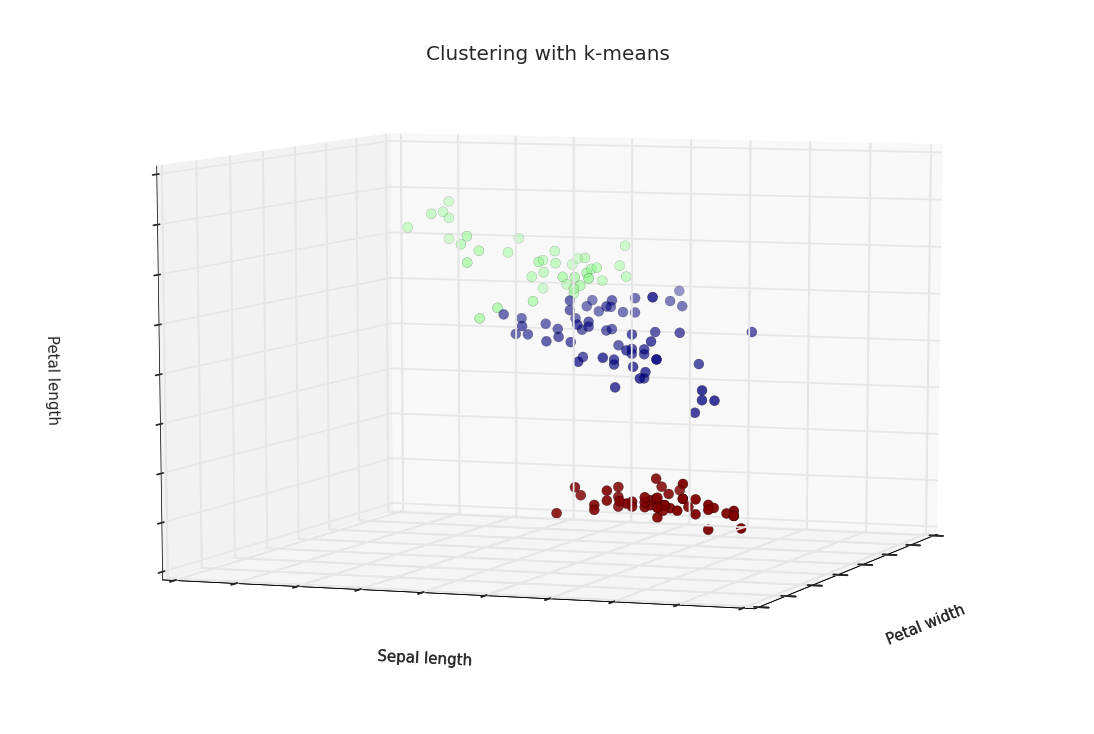

K-means time:  0.027427196502685547


In [59]:
# the sourcecode in this cell is inspired from 
# https://gist.github.com/bbarrilleaux/9841297

# load data
iris = datasets.load_iris()
X_iris = iris.data
y_iris = iris.target
# do the clustering
t0 = time()
centers = kmeans(X_iris, k=3)
labels = [find_closest_centroid(p, centers) for p in X_iris]
t1 = time()
#plot the clusters in color
fig = plt.figure(1, figsize=(15, 10))
plt.clf()
ax = Axes3D(fig, rect=[0, 0, 1, 1], elev=8, azim=200)
plt.cla()
colormap = cm.get_cmap('jet')
ax.scatter(X_iris[:, 3], X_iris[:, 0], X_iris[:, 2], c=labels, cmap=colormap, s=100)

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])
ax.set_xlabel('Petal width', fontsize=15)
ax.set_ylabel('Sepal length', fontsize=15)
ax.set_zlabel('Petal length', fontsize=15)
plt.title("Clustering with k-means", fontsize=20)
plt.show()
print("K-means time: ", t1-t0)


In [42]:
print("Number of samples\t\t:", X_iris.shape[0])
print("Sample dimension\t\t:", X_iris.shape[1])
distinct = np.unique(y_iris)
print("Number of labels\t\t:", len(distinct))

Number of samples		: 150
Sample dimension		: 4
Number of labels		: 3


<div class="alert alert-success">
The graph shows that the petal length is the most important information for clustering the Iris dataset as it is able to separate one cluster from the rest. Along the "sepal length" axis there is no meaningful separation between the clusters, same goes for the "petal width" axis. Just by looking at this graph, we might think our algorithm works pretty well.
<br><br>
Let's see what we get by looking at the true labels.
</div>

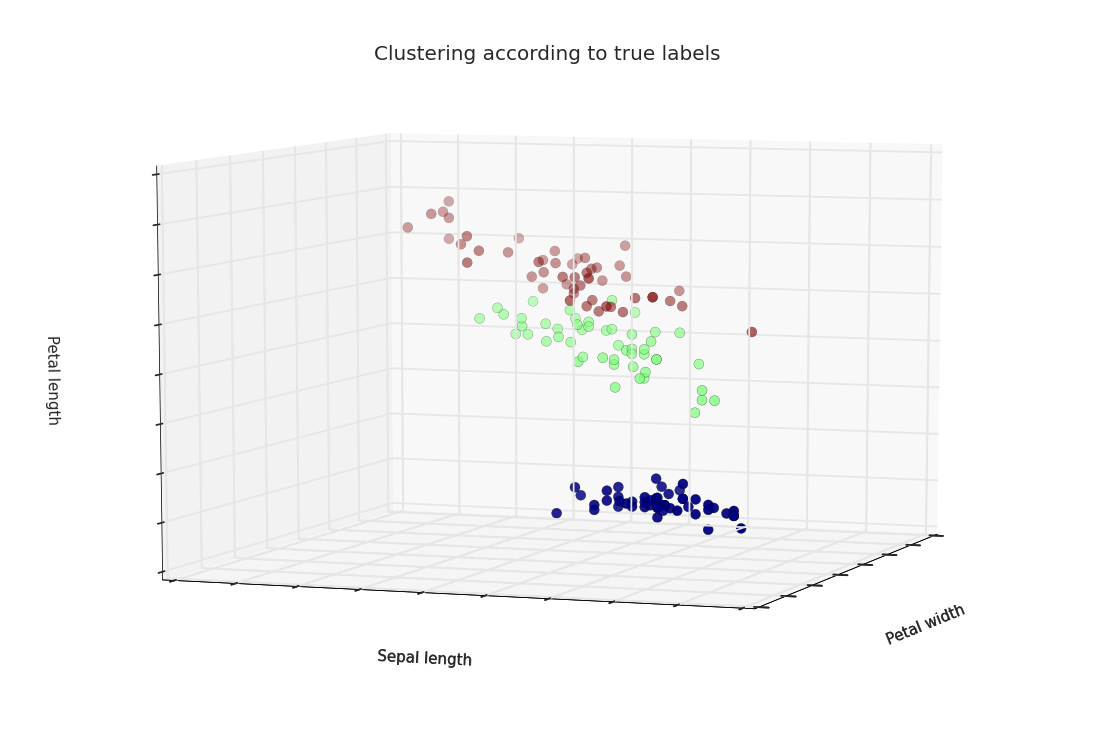

In [62]:
fig = plt.figure(1, figsize=(15, 10))
plt.clf()
ax = Axes3D(fig, rect=[0, 0, 1, 1], elev=8, azim=200)
plt.cla()
colormap = cm.get_cmap('jet')
ax.scatter(X_iris[:, 3], X_iris[:, 0], X_iris[:, 2], c=y_iris, cmap=colormap, s=100)


ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])
ax.set_xlabel('Petal width', fontsize=15)
ax.set_ylabel('Sepal length', fontsize=15)
ax.set_zlabel('Petal length', fontsize=15)
plt.title("Clustering according to true labels", fontsize=20)

plt.show()

<div class="alert alert-success">
Comparing the first graph where we have the predicted clusters with the second one where we plot the data with the labels, we spot some errors on our clustering. Most importantly, we discovered that it does not always provide an acceptable result: the random initialization of the centroids may lead to a worse results, where a group, for example the one with a small petal length, is splitted in two separate clusters, as shown below.
</div>

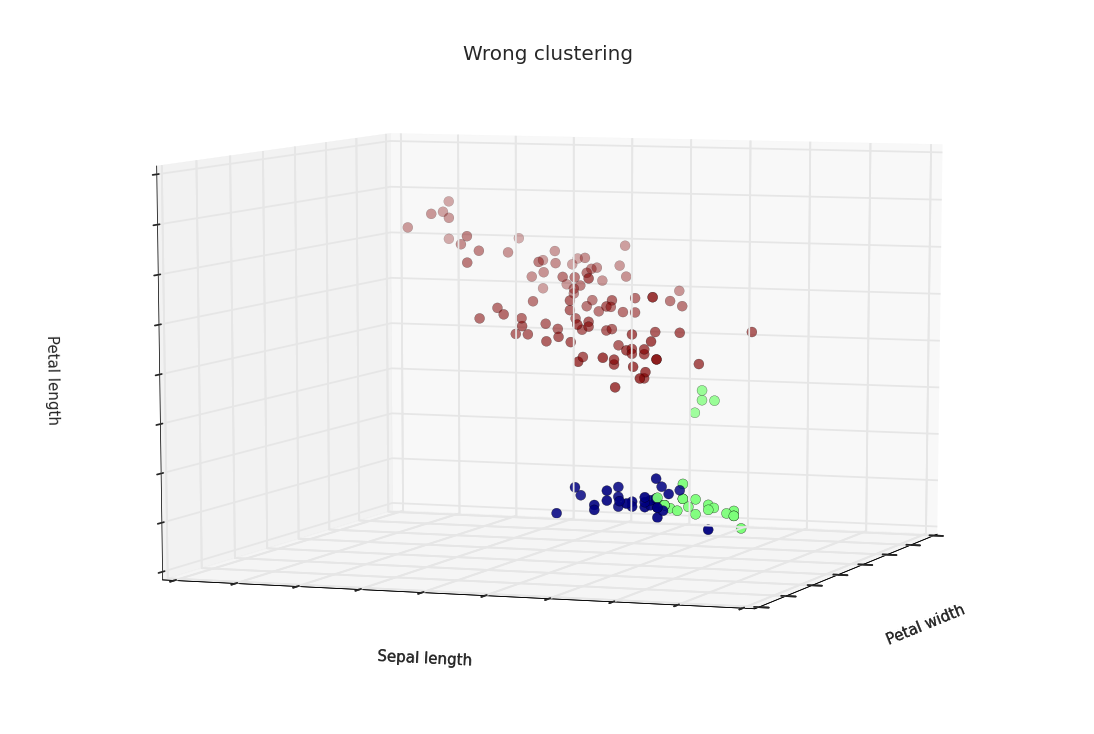

In [65]:
# do the clustering
np.random.seed(2)
centers = kmeans(X_iris, k=3)
labels = [find_closest_centroid(p, centers) for p in X_iris]

#plot the clusters in color
fig = plt.figure(1, figsize=(15, 10))
plt.clf()
ax = Axes3D(fig, rect=[0, 0, 1, 1], elev=8, azim=200)
plt.cla()
colormap = cm.get_cmap('jet')
ax.scatter(X_iris[:, 3], X_iris[:, 0], X_iris[:, 2], c=labels, cmap=colormap, s=100)

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])
ax.set_xlabel('Petal width', fontsize=15)
ax.set_ylabel('Sepal length', fontsize=15)
ax.set_zlabel('Petal length', fontsize=15)
plt.title("Wrong clustering", fontsize=20)
plt.show()

<div class="alert alert-success">
From this result we can already argue that our algorithm is not reliable and robust.
<br><br>
What if we change dataset?
</div>

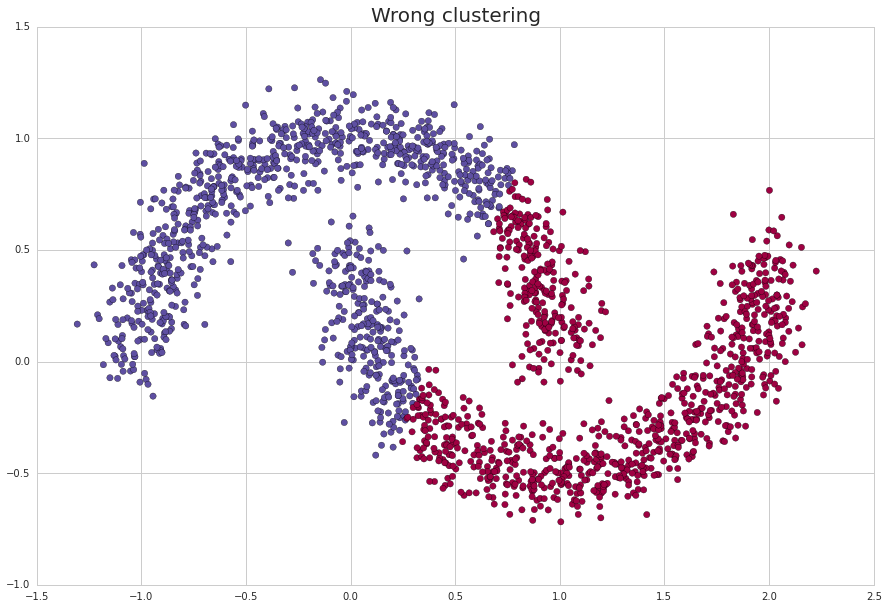

In [8]:
# moon
np.random.seed(0)
X, y = datasets.make_moons(2000, noise=0.1)
plt.figure(figsize=(15,10))
centers = kmeans(X, k=2)
labels = [find_closest_centroid(p, centers) for p in X]
plt.scatter(X[:,0], X[:,1], s=40, c=labels, cmap=plt.cm.Spectral)
plt.title("Wrong clustering", fontsize=20)
plt.show()

<div class="alert alert-success">
The performances of our algorithm strongly depend on what kind of spatial distribution our data set have; the graph above is an example of wrong clustering as we'd like to split the points according to the half-moon they belong to. In the next two figures, we display how bad our k-means algorithm can perform on an easy-clusterable data set, just because we initialize our centroids with a different value, i.e. setting a seed.
</div>

<div class="alert alert-success">
We now show how it is possible to cluster in a more correct way this kind of data set using DBSCAN, a powerful clustering algorithm that discovers clusters of arbitrary shapes and sizes. Relying on a density-based notion of clusters: high-density regions of the space, separated by low-density areas. This algorithm perfectly fits our unsupervised analysis, because it is not necessary to specify a-priori difficult to set parameters such as the number of clusters to identify.
</div>

In [9]:
X = StandardScaler().fit_transform(X)
db = DBSCAN(eps=0.25, min_samples=10).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

print('Estimated number of clusters: %d' % n_clusters_)
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, labels))

/opt/conda/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)


Estimated number of clusters: 2
Silhouette Coefficient: 0.279


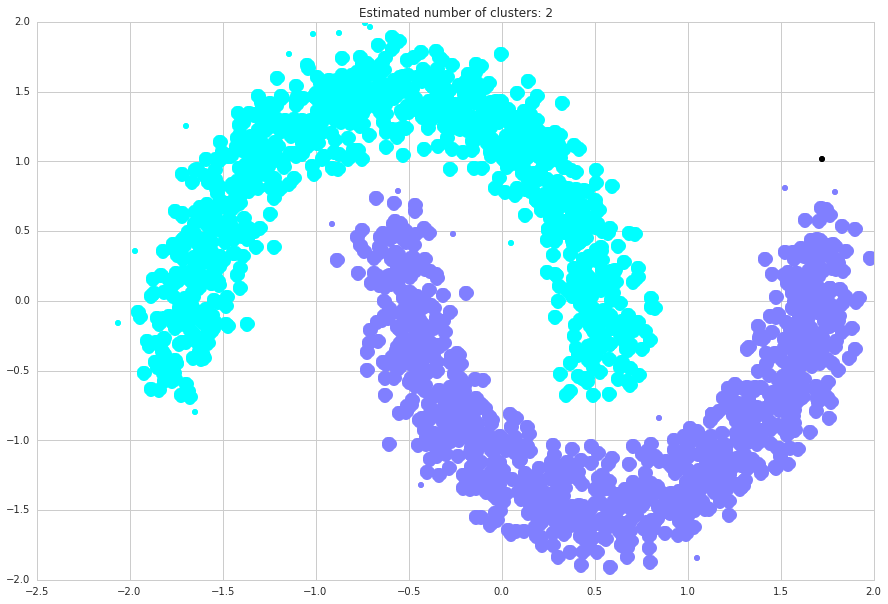

Number of outliers:  1


In [19]:
unique_labels = set(labels)
colors = plt.cm.cool(np.linspace(0, 1, len(unique_labels)))
outliers = 0
plt.figure(figsize=[15, 10])
for k, col in zip(unique_labels, colors):
    if k == -1:
        col = 'k'
        outliers += 1
    class_member_mask = (labels == k)

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=col,
             markeredgecolor='b', markersize=15)

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=col,
             markeredgecolor='b', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()
print("Number of outliers: ", outliers)

<div class="alert alert-success">
The image above shows an example of DBSCAN in action on points in the plane. The algorithm automatically defined two clusters. The large points had enough close neighbors to agglomerate those points, while the small colored points did not agglomerate themselves but are within the ε-radius of a large point. The points in black are the outliers (here, only one). We should also note that DBSCAN provides better results in low-dimensional spaces, because high-dimensional spaces are usually sparse, making it difficult to distinguish between high and low density regions. This could become an issue when dealing with connections where we usually have many feature to play with.
</div>

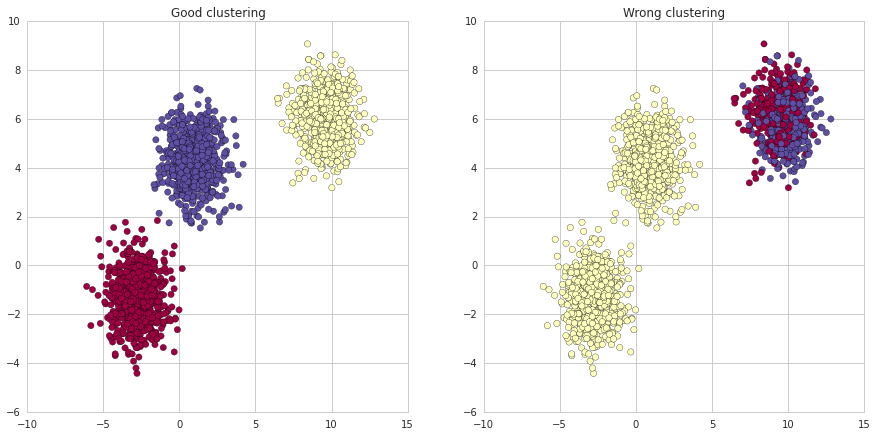

In [28]:
# blob
X, y = datasets.make_blobs(n_samples=2000, centers=3, n_features=20, random_state=0)
plt.figure(figsize=(15,7))
plt.subplot(1,2,1)
centers = kmeans(X, k=3)
labels = [find_closest_centroid(p, centers) for p in X]
plt.title("Good clustering")
plt.scatter(X[:,0], X[:,1], s=40, c=labels, cmap=plt.cm.Spectral)

np.random.seed(0)
X, y = datasets.make_blobs(n_samples=2000, centers=3, n_features=20, random_state=0)
plt.subplot(1,2,2)
centers = kmeans(X, k=3)
labels = [find_closest_centroid(p, centers) for p in X]
plt.title("Wrong clustering")
fig = plt.figure(1, figsize=(8, 8))
plt.scatter(X[:,0], X[:,1], s=40, c=labels, cmap=plt.cm.Spectral)
plt.show()

<div class="alert alert-success">
On the left, points are correctly clustered, while on the right we clearly get a wrong prediction.
<br><br>
We want to see how slower our k-means implementation is, compared to the sci-kit learn implementation.
</div>

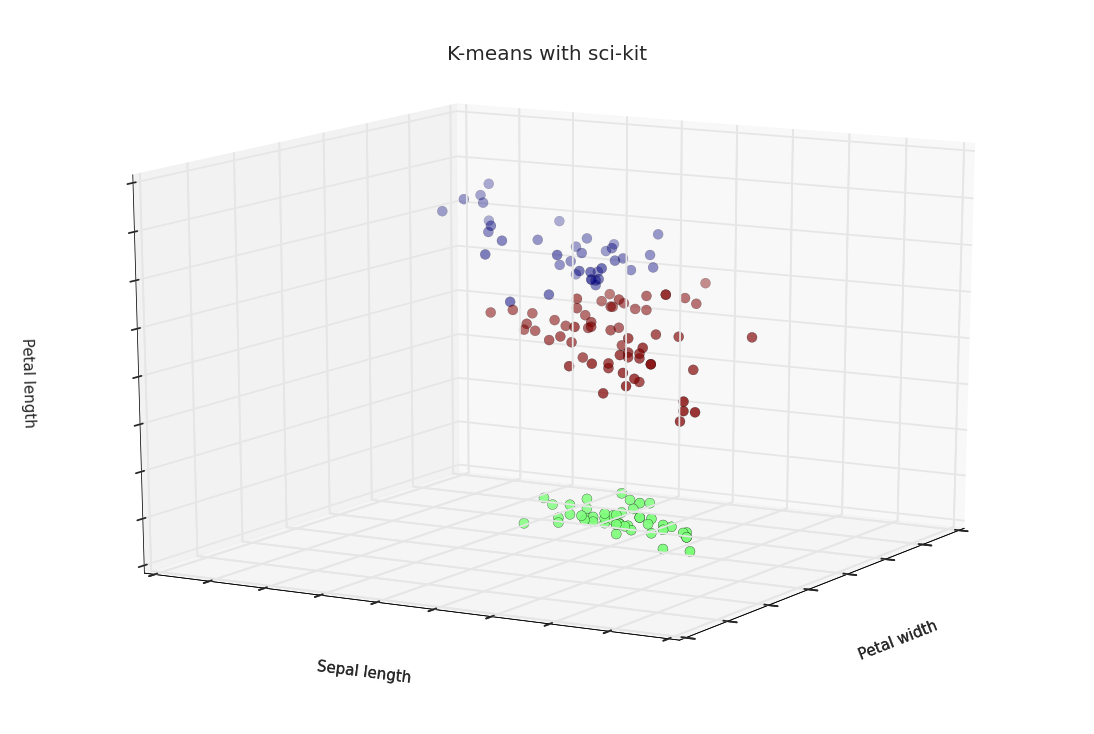

K-means time:  0.03588438034057617


In [77]:
# Here we use sci-kit learn implementation of K-means
t0 = time()
centers = cluster.KMeans(n_clusters=3, max_iter=1000)
centers.fit(X_iris) 
labels = centers.labels_
t1 = time()
#plot the clusters in color
fig = plt.figure(1, figsize=(15, 10))
plt.clf()
ax = Axes3D(fig, rect=[0, 0, 1, 1], elev=15, azim=210)
plt.cla()
colormap = cm.get_cmap('jet')
ax.scatter(X_iris[:, 3], X_iris[:, 0], X_iris[:, 2], c=labels, cmap=colormap, s=100)

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])
ax.set_xlabel('Petal width', fontsize=15)
ax.set_ylabel('Sepal length', fontsize=15)
ax.set_zlabel('Petal length', fontsize=15)
plt.title("K-means with sci-kit", fontsize=20)
plt.show()
print("K-means time: ", t1-t0)

<div class="alert alert-success">
Using the sci-kit version of k-means we get not only a smaller execution time, but also we don't run into problems of bad centroids initialization. This is due to all the optimizations and features of the sklearn module: by default the k-means algorithm runs 10 times with different centroid seed. The final results will be the best output of 10 consecutive runs in terms of inertia (the within-cluster sum of squares criterion which can be recognized as a measure of how internally coherent clusters are). Furthermore, the initialization method is k-means++, which is able to speed up convergence. Indeed, with the k-means++ initialization, the algorithm is guaranteed to find a solution that is <i>O(log k)</i> competitive to the optimal k-means solution.
</div>

That's enough about K-means for now. In the next section, we will apply MMLIB's K-means on Spark to deal with a large data in the real usecase.


# 2. Usecase: Network Intrusion 

Some attacks attempt to flood a computer with network traffic. In some other cases, attacks attempt to exploit flaws in networking software in order to gain unauthorized access to a computer. Detecting an exploit in an incredibly large haystack of network requests is not easy.

Some exploit behaviors follow known patterns such as scanning every port in a short of time, sending a burst of request to a port... However, the biggest threat may be the one that has never been detected and classified yet. Part of detecting potential network intrusions is detecting anomalies. These are connections that aren't known to be attacks, but, do not resemble connections that have been observed in the past.

In this notebook, K-means is used to detect anomalous network connections based on statistics about each of them.


## 2.1. Data
The data comes from [KDD Cup 1999](http://kdd.ics.uci.edu/databases/kddcup99/kddcup99.html). The dataset is about 708MB and contains about 4.9M connections. For each connection, the data set contains information like the number of bytes sent, login attempts, TCP errors, and so on. Each connection is one line of CSV-formatted data, containing 38 features: back, buffer_overflow, ftp_write, guess_passwd, imap, ipsweep, land, loadmodule, multihop, neptune, nmap, normal, perl, phf, pod, portsweep, rootkit, satan, smurf, spy, teardrop, warezclient, warezmaster. For more details about each feature, please follow this [link](http://kdd.ics.uci.edu/databases/kddcup99/kddcup99.html).

Many features take on the value 0 or 1, indicating the presence or absence of a behavior such as `su_attempted` in the 15th column. Some features are counts, like `num_file_creations` in the 17th columns. Some others are the number of sent and received bytes.

## 2.2. Clustering without using categorical features

First, we need to import some packages that are used in this notebook.

In [11]:
import os
import sys
import re
from pyspark import SparkContext
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql.types import *
from pyspark.sql import Row
from pyspark.sql.functions import *
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pyspark.sql.functions as func
import matplotlib.patches as mpatches
from pyspark.mllib.clustering import KMeans, KMeansModel

input_path = "/datasets/k-means/kddcup.data"
raw_data = sc.textFile(input_path, 36).cache()

### 2.2.1. Loading data

There are two types of features: numerical features and categorical features.
Currently, to get familiar with the data and the problem, we only use numerical features. In our data, we also have pre-defined groups for each connection, which we can use later as our "ground truth" for verifying our results.

**Note 1**: we don't use the labels in the training phase!!!

**Note 2**: in general, since clustering is un-supervised, you don't have access to ground truth. For this reason, several metrics to judge the quality of clustering have been devised. For a short overview of such metrics, follow this [link](https://en.wikipedia.org/wiki/Cluster_analysis#Internal_evaluation). Note that computing such metrics, that is trying to assess the quality of your clustering results, is as computationally intensive as computing the clustering itself!

#### Question 2
<div class="alert alert-info">

Write function `parseLine` to construct a tuple of `(label, vector)` for each connection, extract the data that contains only the data points (without label), then print the number of connections.

</div>

Where,

* `label` is the pre-defined label of each connection
* `vector` is a numpy array that contains values of all features, but the label and the categorial features at index `1,2,3` of each connection. Each `vector` is a data point.

```python
def parseLine(line):
    cols = line...
    # label is the last column
    label = ...
    
    # vector is every column, except the label
    vector = ...
    
    # delete values of columns that have index 1->3 (categorical features)
    ...
    
    # convert each value from string to float
    vector = np.array(...)
    
    return (label, vector)

labelsAndData = raw_data.map(...)

# we only need the data, not the label
data = labelsAndData...cache()

# number of connections
n = data....
```

In [12]:
def parseLine(line):
    cols = line.split(',')
    # label is the last column
    label = cols[-1]
    
    # vector is every column, except the label
    vector = cols[:-1]
    
    # delete values of columns that have index 1->3 (categorical features)
    del vector[1:4]
    
    # convert each value from string to float
    vector = np.array(vector, dtype=np.float)
    
    return (label, vector)

In [13]:
t0 = time()
labelsAndData = raw_data.map(parseLine)
t1 = time()
# we only need the data, not the label
data = labelsAndData.values().cache()
t2 = time()
# number of connections
n = data.count()
t3 = time()
print("Number of connections: ", n)
print("Time to parse the lines: ", t1-t0)
print("Time to retrieve the values and cache them: ", t2-t1)
print("Time to count: ", t3-t2)
print("Number of features before parsing : ", len(raw_data.first().split(",")))
print("Number of features after parsing  : ", len(data.first()))

Number of connections:  4898431
Time to parse the lines:  0.000186920166015625
Time to retrieve the values and cache them:  0.02931070327758789
Time to count:  16.269351720809937
Number of features before parsing :  42
Number of features after parsing  :  38


<div class="alert alert-success">
We correctly removed 3 features and the label.
We're dealing with almost 5 millions connections.
<br>
We already know that Spark is a lazy-evaluation framework and this is consistent with the times we printed above: map, for instance, is not executed until the next action (count in this case) is run. 
</div>

#### Question 3
<div class="alert alert-info">

Using K-means algorithm of MLLIB, cluster the connections into two groups then plot the result. Why two groups? In this case, we are just warming up, we're testing things around, so "two groups" has no particular meaning.

</div>  

You can use the following parameters:  

<ul>

  <li>`maxIterations=10`</li>
  <li>`runs=10`</li>
  <li>`initializationMode="random"`</li>

</ul>  

Discuss the result from your figure.

In [14]:
t0 = time()
clusters = KMeans.train(data, 2, maxIterations=10, initializationMode="random")
t1 = time()
print("Computational Time: %.2f s" % (t1-t0))

Computational Time: 8.03 s


<div class="alert alert-success">
We are curious about the computational time and how it changes with the amount of data we use. Let's check.
</div>


In [86]:
execTime = []
for i in range(100):
    if (i+1)%10 == 0:
        print('|', end='')
    else:
        print('.', end='')
        
    fraction = 0.01*(i+1)
    sampledData = data.sample(False, fraction)
    t0 = time()
    clusters = KMeans.train(sampledData, 2, maxIterations=10, initializationMode="random")
    execTime.append((sampledData.count(), fraction, time()-t0))

.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|

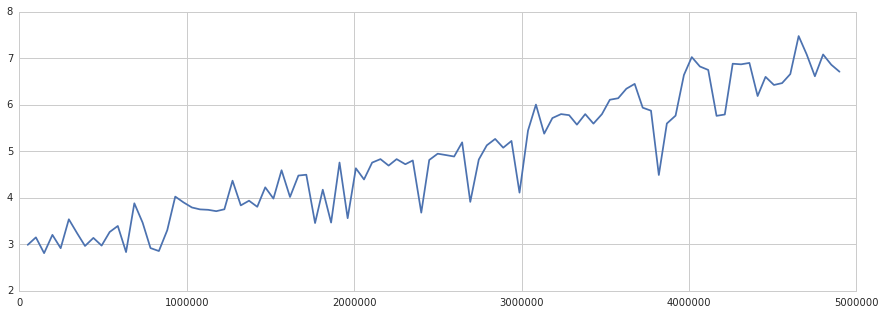

In [87]:
df = pd.DataFrame(execTime, columns=['samples', 'fraction', 'time'])
plt.figure(figsize=[15, 5])
plt.plot(df['samples'], df['time'])
plt.show()

<div class="alert alert-success">
Running time shows a linear trend with the number of samples used. Nevertheless, the algorithm is sometimes able converge slower or faster depending on the initial random assignment of centroids. This explains the peaks, mostly downwards. 
</div>


In [88]:
clusters = KMeans.train(data, 2, maxIterations=10, initializationMode="random")

<div class="alert alert-success">
Since we have only two clusters, we think it's almost impossible to plot meaningful data. We, instead, prefer to use Question 5 to show differences in cluster assignments. 
</div>

### 2.2.3. Evaluating model

#### Question 4
<div class="alert alert-info">

One of the simplest method to evaluate our result is calculate the Within Set Sum of Squared Errors (WSSSE), or simply, 'Sum of Squared Errors'. An error of a data point is defined as it's distance to the closest cluster center.

</div>


```python
from operator import add

# Evaluate clustering by computing Within Set Sum of Squared Errors
def error(clusters, point):
    closest_center = ...
    return ...

WSSSE = data.map(...).reduce(...)
print("Within Set Sum of Squared Error = " + str(WSSSE))
```

In [13]:
def error(clusters, point):
    closest_center = clusters.centers[clusters.predict(point)]
    return euclidean_distance(closest_center, point)**2

In [15]:
# Evaluate clustering by computing Within Set Sum of Squared Errors
t0 = time()
WSSSE = data.map(lambda point: error(clusters, point)).reduce(operator.add)
print("Within Set Sum of Squared Error: " + str(WSSSE))
t1 = time()
print("WSSSE computational time: ", t1- t0)

Within Set Sum of Squared Error: 3.05254895755e+18
WSSSE computational time:  16.105849027633667


<div class="alert alert-success">
By looking at the <a href='http://spark.apache.org/docs/1.5.2/api/python/pyspark.mllib.html#pyspark.mllib.clustering.KMeansModel.computeCost'>source code</a> of the `pyspark.mllib.clustering` module we found the `computeCost()` method of the `KMeansModel` class. According to the documentation, "it returns the sum of squared distances of points to their nearest center given data", as we just did, but it is optimized, hence faster.

</div>

In [16]:
t0= time()
WSSSE = clusters.computeCost(data)
t1= time()
print("Within Set Sum of Squared Error: " + str(WSSSE))
print("WSSSE computational time: :", (t1-t0))

Within Set Sum of Squared Error: 3.0525489575477893e+18
WSSSE computational time: : 3.5288593769073486


<div class="alert alert-success">
As we can see, using the built-in method the model score is computed up to 5 times faster than before.
</div>


#### Question 5

<div class="alert alert-info">

This is a good opportunity to use the given labels to get an intuitive sense of what went into these two clusters, by counting the labels within each cluster. Complete the following code that uses the model to assign each data point to a cluster, and counts occurrences of cluster and label pairs.  

What do you think about the result?

</div>

```python
clusterLabelCount = ...

for item in clusterLabelCount:
    print(item)
```

In [96]:
t0 = time()
clusterLabelCount = labelsAndData.map(lambda row: ((clusters.predict(row[1]), \
                                    row[0]), 1)).reduceByKey(operator.add).collect()
t1 = time()
label = 0
for item in clusterLabelCount:
    label += 1
    print("Label #", label, end="\t")
    print(item)
print("Time: ", (t1-t0))

Label # 1	((1, 'imap.'), 12)
Label # 2	((1, 'satan.'), 15892)
Label # 3	((1, 'portsweep.'), 10408)
Label # 4	((1, 'guess_passwd.'), 53)
Label # 5	((1, 'normal.'), 972781)
Label # 6	((1, 'nmap.'), 2316)
Label # 7	((1, 'spy.'), 2)
Label # 8	((1, 'ftp_write.'), 8)
Label # 9	((0, 'portsweep.'), 5)
Label # 10	((1, 'perl.'), 3)
Label # 11	((1, 'land.'), 21)
Label # 12	((1, 'smurf.'), 2807886)
Label # 13	((1, 'warezmaster.'), 20)
Label # 14	((1, 'phf.'), 4)
Label # 15	((1, 'ipsweep.'), 12481)
Label # 16	((1, 'back.'), 2203)
Label # 17	((1, 'teardrop.'), 979)
Label # 18	((1, 'pod.'), 264)
Label # 19	((1, 'neptune.'), 1072017)
Label # 20	((1, 'multihop.'), 7)
Label # 21	((1, 'loadmodule.'), 9)
Label # 22	((1, 'warezclient.'), 1020)
Label # 23	((1, 'rootkit.'), 10)
Label # 24	((1, 'buffer_overflow.'), 30)
Time:  15.728753805160522


<div class="alert alert-success">
The first aspect to notice in this dataset is that we are not dealing with common data in that the proportion of attack instances to normal ones is very large. This implies that when we will try to detect anomalies, we will probably get both normal and malicious connections that differ from the 'standard' way of performing normal or malicious connections.
<br>
<br>
We have 24 labels and 2 clusters, one cluster contains 5 elements (out of almost 5 millions), all belonging to the same label. The only information we get from our result is that using <i>k</i> = 2 gives us an unbalanced clustering and maybe it's not so useful.
<br><br>
Let's try to understand a bit more how this is possible by looking at how our data points are placed using only 3 dimensions that we think are meaningful for a connection.
</div>

In [97]:
cluster0 = labelsAndData.filter(lambda x : x[0] == 'portsweep.').map(lambda x:x[1:][0]).take(5)
cluster1 = labelsAndData.map(lambda x:x[1:][0]).take(250)

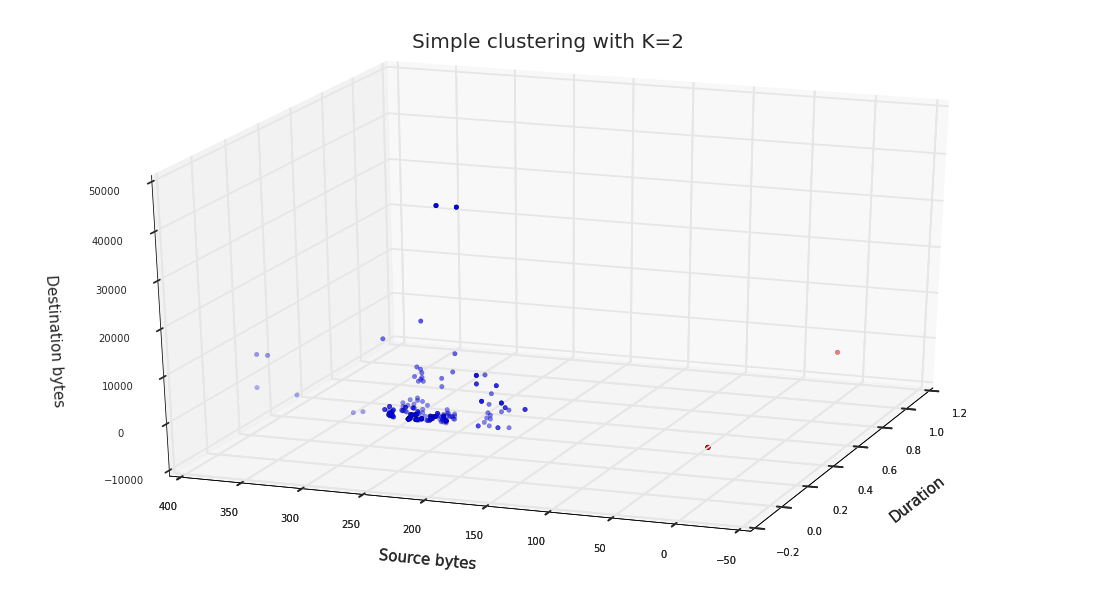

In [98]:
cluster0=np.asarray(cluster0)
cluster1=np.asarray(cluster1)

fig = plt.figure(1, figsize=(15, 8))
plt.clf()
ax = Axes3D(fig, rect=[0, 0, 1, 1], elev=25, azim=200)
plt.cla()
ax.scatter(cluster0[:, 0], cluster0[:, 1], cluster0[:, 2], c='r')
ax.scatter(cluster1[:, 0], cluster1[:, 1], cluster1[:, 2], c='b')

#ax.w_xaxis.set_ticklabels([])
#ax.w_yaxis.set_ticklabels([])
#ax.w_zaxis.set_ticklabels([])
ax.set_xlabel('Duration',fontsize=15)
ax.set_ylabel('Source bytes',fontsize=15)
ax.set_zlabel('Destination bytes',fontsize=15)
plt.title("Simple clustering with K=2",fontsize=20)
plt.show()

In [99]:
cluster0[:,:3]

array([[ 0.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 0.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 0.,  0.,  0.]])

<div class="alert alert-success">
We found out that connections associated to some portsweep-labeled data have a duration equal to 0 or 1 second, but the big difference with the other data points in this 3-D representation is that the amount of sent or received bytes is zero. This could be the possible reason for this drastic split, even though we are not considering all the other features. 
<br><br>
A port sweep is a scan of multiple hosts for one port [1]. Scanning all the addresses in a 24 bit address space (what used to be called a class C netblock) for port 80 would be an example of a port sweep.
</div>

### 2.2.4. Choosing K

How many clusters are appropriate for a dataset? In particular, for our own dataset, it's clear that there are 23 distinct behavior patterns in the data, so it seems that k could be at least 23, or likely, even more. In other cases, we even don't have any information about the number of patterns at all (remember, generally your data is not labelled!). Our task now is finding a good value of $k$. For doing that, we have to build and evaluate models with different values of $k$. A clustering could be considered good if each data point were near to its closest centroid. One of the ways to evaluate a model is calculating the Mean of Squared Errors of all data points.

#### Question 6
<div class="alert alert-info">
Complete the function below to calculate the MSE of each model that is corresponding to each value of $k$.  


Plot the results. From the obtained result, what is the best value for $k$? Why?

</div>

```python
# k: the number of clusters
def clusteringScore(data, k):
    clusters = KMeans....
    # calculate mean square error
    return ...

scores = ...
for score in scores:
    print(score)
    
# plot results
plt...
```

In [25]:
# k: the number of clusters
def clusteringScore(data, k):
    clusters = KMeans.train(data, k, maxIterations=10, runs=1, initializationMode="random")
    # calculate mean square error
    return (clusters.computeCost(data)/n)

In [101]:
scores = []
execTime = []
t0 = time()

for k in range(2,25):
    scores.append(clusteringScore(data, k))
    t1 = time()
    execTime.append(t1-t0)
    print("Number of clusters: %d \t Execution Time: %.2f s" % (k, (t1-t0)))
    t0 = t1

Number of clusters: 2 	 Execution Time: 7.83 s
Number of clusters: 3 	 Execution Time: 8.87 s
Number of clusters: 4 	 Execution Time: 9.25 s
Number of clusters: 5 	 Execution Time: 10.11 s
Number of clusters: 6 	 Execution Time: 10.23 s
Number of clusters: 7 	 Execution Time: 10.92 s
Number of clusters: 8 	 Execution Time: 10.50 s
Number of clusters: 9 	 Execution Time: 10.23 s
Number of clusters: 10 	 Execution Time: 10.21 s
Number of clusters: 11 	 Execution Time: 9.65 s
Number of clusters: 12 	 Execution Time: 10.56 s
Number of clusters: 13 	 Execution Time: 10.60 s
Number of clusters: 14 	 Execution Time: 10.75 s
Number of clusters: 15 	 Execution Time: 10.19 s
Number of clusters: 16 	 Execution Time: 10.15 s
Number of clusters: 17 	 Execution Time: 10.30 s
Number of clusters: 18 	 Execution Time: 10.34 s
Number of clusters: 19 	 Execution Time: 10.97 s
Number of clusters: 20 	 Execution Time: 10.61 s
Number of clusters: 21 	 Execution Time: 9.98 s
Number of clusters: 22 	 Executio

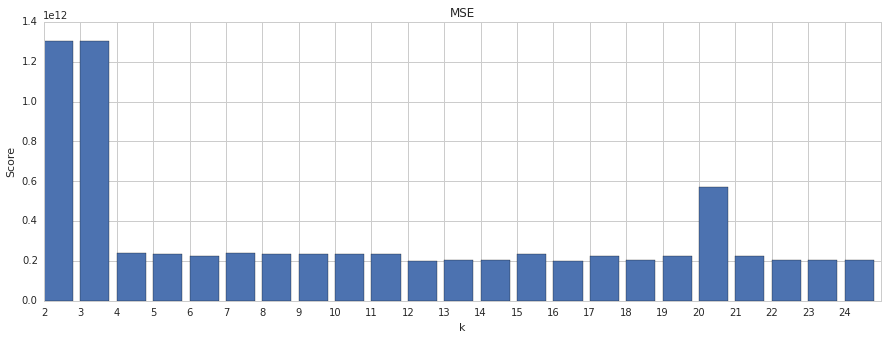

In [102]:
plt.figure(figsize=[15,5])
plt.title('MSE')
plt.xlabel("k")
plt.ylabel("Score")
plt.bar(range(23), scores)
plt.xticks(range(24),[k for k in range(2,25)])
plt.xlim(0, 23)
plt.show()

<div class="alert alert-success">
Ideally, one should get a decreasing MSE as <i>k</i> increases, but we don't see this trend in our plot, or at least it's not so clear. This is probably due to two reasons: the algorithm does not find global minima for every value of <i>k</i> and the data are not easily clusterable, perhaps because they are in a space with 38 dimensions and some of them represent only noise.
<br>Increasing the value of <i>k</i> implies a small increment on the overall training time.
<br><br>
KMeans.train does not support multiple runs as parameter anymore, so one should manually run the training more than once to correctly evaluate the model.
</div>

In [11]:
scores = []

runs = 10
for k in range(2,25):
    tmp = 0
    for i in range(runs):
        s = clusteringScore(data, k)
        tmp += s
    score = tmp/runs
    scores.append(score)


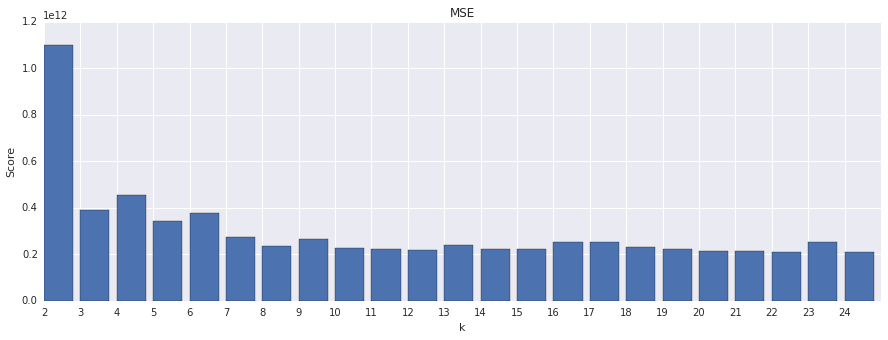

In [12]:
plt.figure(figsize=[15,5])
plt.title('MSE')
plt.xlabel("k")
plt.ylabel("Score")
plt.bar(range(23), scores)
plt.xticks(range(24),[k for k in range(2,25)])
plt.xlim(0, 23)
plt.show()

<div class="alert alert-success">
By running 10 simulations for each value of $k$ we get a more precise idea about which value we should choose. Indeed, from the graph above we are closer to the ideal behavior where the score decreases with $k$.
</div>

### 2.2.5 Normalizing features

K-means clustering treats equally all dimensions/directions of the space and therefore tends to produce more or less spherical (rather than elongated) clusters. In this situation, leaving variances uneven is equivalent to putting more weight on variables with smaller variance, so clusters will tend to be separated along variables with greater variance.

In our notebook, since Euclidean distance is used, the clusters will be influenced strongly by the magnitudes of the variables, especially by outliers. Normalizing will remove this bias. 

Each feature can be normalized by converting it to a standard score. This means subtracting the mean of the feature’s values from each value, and dividing by the standard deviation

$normalize_i=\frac{feature_i - \mu_i}{\sigma_i}$

Where,

* $normalize_i$ is the normalized value of feature $i$
* $\mu_i$ is the mean of feature $i$
* $\sigma_i$ is the standard deviation of feature $i$


![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

#### Question 7
<div class="alert alert-info">

Complete the code below to normalize the data. Print the first 5 lines of the new data.

</div>

<div class="label label-success">HINT</div> If $\sigma_i = 0$ then $normalize_i=feature_i - \mu_i$

```python
def normalizeData(data):
    # number of connections
    n = ...

    # calculate the sum of each feature
    sums = ...
    print(sums)

    # calculate means
    means = ...

    # calculate the sum square of each feature
    sumSquares = ...
    print(sumSquares)

    # calculate standard deviation of each feature
    stdevs = ...
    print(stdevs)

    def normalize(point):
        return ...

    return data.map(normalize)

normalizedData = normalizeData(data).cache()
print(normalizedData.take(5))
```

In [14]:
def normalizeData(data):
    # calculate means
    means = data.mean()    

    # calculate standard deviation of each feature
    stdevs = data.stdev()
    print(stdevs)

    stdevs[stdevs==0] = 1
    
    def normalize(point):
        return (point - means) / stdevs

    return data.map(normalize)

In [8]:
t0 = time()
normalizedData = normalizeData(data).cache()
t1 = time()
print("Execution time: %.2f s" % (t1-t0))

[  7.23329737e+02   9.41430978e+05   6.45012268e+05   2.39083319e-03
   4.28543324e-02   7.21508295e-03   4.68978117e-01   7.29940683e-03
   3.50611523e-01   3.85648064e+00   8.25714534e-03   8.08243095e-03
   3.93807490e+00   1.24185736e-01   8.73758872e-03   3.55104777e-02
   0.00000000e+00   6.38978745e-04   2.88871577e-02   2.11990761e+02
   2.45992685e+02   3.81875553e-01   3.82254047e-01   2.32252900e-01
   2.32660379e-01   3.89295798e-01   8.27145751e-02   1.40559550e-01
   6.40209308e+01   1.05912757e+02   4.11185973e-01   1.08543203e-01
   4.80987669e-01   4.12597750e-02   3.81838168e-01   3.82177399e-01
   2.30942796e-01   2.30977686e-01]
Execution time: 10.75 s


In [9]:
pprint(normalizedData.take(5))

[array([ -6.68331854e-02,  -1.72038228e-03,   6.81884351e-02,
        -2.39084686e-03,  -1.51391734e-02,  -1.10348462e-03,
        -2.65207600e-02,  -4.39091558e-03,   2.44279187e+00,
        -2.09732783e-03,  -8.25770840e-03,  -4.54646139e-03,
        -3.28458917e-03,  -9.57233922e-03,  -8.50457842e-03,
        -2.87561127e-02,   0.00000000e+00,  -6.38979005e-04,
        -2.89113034e-02,  -1.57541507e+00,  -1.19624324e+00,
        -4.66042614e-01,  -4.65755574e-01,  -2.48285775e-01,
        -2.48130352e-01,   5.39733093e-01,  -2.56056520e-01,
        -2.01059296e-01,  -3.63913926e+00,  -1.78651044e+00,
        -1.83302273e+00,  -2.82939000e-01,  -1.25793664e+00,
        -1.56668488e-01,  -4.66404784e-01,  -4.65453641e-01,
        -2.50831829e-01,  -2.49631966e-01]),
 array([ -6.68331854e-02,  -1.77667956e-03,   5.32451452e-03,
        -2.39084686e-03,  -1.51391734e-02,  -1.10348462e-03,
        -2.65207600e-02,  -4.39091558e-03,   2.44279187e+00,
        -2.09732783e-03,  -8.25770840e

![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

#### Question 8
<div class="alert alert-info">

Using the new data, build different models with different values of $k \in [60,70,80,90,100,110]$. Evaluate the results by plotting them and choose the best value of $k$.

</div>

```python
scores = ...
for score in scores:
    print(score)

plt...
```

[15.030315823842978, 13.590569060954888, 13.667805394922766, 13.184474972319919, 13.220959531238378, 12.918343440596493]


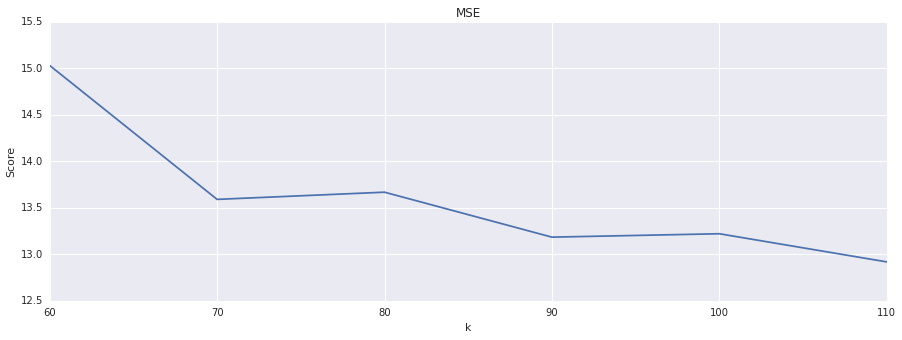

In [47]:
print(scoresNorm)
range_k = range(60, 111, 10)
plt.figure(figsize=[15, 5])
plt.title('MSE')
plt.xlabel("k")
plt.ylabel("Score")
plt.plot(range_k, scoresNorm)
plt.xticks(range(60, 111, 10),[k for k in range(60, 111, 10)])
plt.show()

<div class='alert alert-success'>
From this graph we can draw some conclusions:
<ul>
<li>if we want to choose the best value of <i>k</i> using this approach, we need to run the K-means algorithm multiple times and then average the scores, this will yield a decreasing score as <i>k</i> increases</li>
<li>normalizing the data allowed us to decrease by orders of magnitude the MSE</li>
<li>random initialization of the centroids remains a big issue</li>
</ul>
</div>

![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

#### Question 9
<div class="alert alert-info">

Plot the clustering result to see the difference between before and after normalizing features. Discuss about the difference and explain why and if normalization was useful.

</div>

<div class="alert alert-success">
To discuss the result before and after the feature normalisation we decided to proceed with this strategy:
<ul>
<li> Take the 3 most informative features </li>
<li>Run without normalisation with K = 100 and for each cluster plot their 3-top important feature</li>
<li>Run with normalisation with K = 100 and for each cluster plot their 3-top important feature</li>
</ul>
</div>

In [111]:
label_translation = {'back.':0,'buffer_overflow.':1,'ftp_write.':2,'guess_passwd.':3,\
                     'imap.':4,'ipsweep.':5,'land.':6,'loadmodule.':7,'multihop.':8,'neptune.':9,'nmap.':10,\
                     'normal.':11, 'perl.':12,'phf.':13,'pod.':14,'portsweep.':15,'rootkit.':16,'satan.':17,\
                     'smurf.':18,'spy.':19,'teardrop.':20,'warezclient.':21,'warezmaster.':22}


def parseLineWithLabelTranslation(line):
    cols = line.split(',')
    # label is the last column
    label = cols[-1]
    
    # vector is every column, except the label
    vector = cols[:-1]
    
    # delete values of columns that have index 1->3 (categorical features)
    del vector[1:4]
    
    # convert each value from string to float
    vector = np.array(vector, dtype=np.float)
    
    return (label_translation[label], vector)

tmp = raw_data.map(parseLineWithLabelTranslation)

<div class="alert alert-success">
To get the most important feature for this problem, we decided to use a simple decision tree do get the most informative features of this dataset. Since this was only for visualisation purpose, to do so we use the sklearn implementation (not distributed) on only the 20% of the dataset.
</div>

In [112]:
tmp_limited = tmp.take(1000000)
X = np.array(list(map(lambda x:x[1], tmp_limited)))
Y = np.array(list(map(lambda x:x[0], tmp_limited)))
dtc = tree.DecisionTreeClassifier(criterion='gini')
myTree = dtc.fit(X,Y)
feature_importances = myTree.feature_importances_

In [113]:
pprint(feature_importances)
top3features = np.argsort(feature_importances)[-3:].tolist()
print(top3features)

array([  8.09137580e-06,   3.44664282e-01,   1.70408791e-03,
         1.97702776e-05,   6.04319349e-04,   3.30413933e-06,
         1.23901318e-05,   9.72581538e-05,   5.94463878e-05,
         5.58544063e-03,   1.29136493e-06,   0.00000000e+00,
         4.44582723e-06,   4.36688091e-06,   4.61374694e-06,
         1.42104381e-05,   0.00000000e+00,   0.00000000e+00,
         3.34653074e-06,   5.72533370e-01,   2.14791924e-03,
         4.78935668e-06,   7.93605611e-05,   2.60952964e-03,
         1.49644795e-05,   1.90975757e-04,   7.67843903e-03,
         2.33208408e-04,   6.76701427e-04,   5.48868002e-05,
         8.49365698e-03,   2.00377940e-03,   6.02425891e-04,
         2.27858515e-02,   2.35142527e-02,   3.05438828e-03,
         4.81566620e-04,   4.92685236e-05])
[34, 1, 19]


<div class="alert alert-success">
Now that we have the top 3 features, we can move to the training both with and without normalisation.
</div>

In [117]:
K = 100
clusters = KMeans.train(data, K, maxIterations=10, initializationMode="random")
clustersNorm = KMeans.train(normalizedData, K, maxIterations=10, initializationMode="random")

In [118]:
fract = 1
dataWithClusterNumber = data.map(lambda x : (x, clusters.predict(x))).cache()
dataNormWithClusterNumber = normalizedData.map(lambda x : (x, clustersNorm.predict(x))).cache()

In [119]:
points = []
pointsNorm = []
for k in range(K):
    points.append(dataWithClusterNumber.filter(lambda x : x[1]==k).map(lambda x : x[0]).take(1000))
    pointsNorm.append(dataNormWithClusterNumber.filter(lambda x : x[1]==k).map(lambda x : x[0]).take(1000))

In [122]:
def plot_clusters3D(points, axis, title, labels=None):
    fig = plt.figure(1, figsize=(15, 8))
    plt.clf()
    ax = Axes3D(fig, rect=[0, 0, 1, 1], elev=15, azim=225)
    plt.cla()
    
    K = len(points)
    colors = iter(cm.jet(np.linspace(0, 1, K)))
    
    for i in range(10):
        if len(points[i]) > 0:
            p = np.asarray(points[i])
            ax.scatter(p[:, axis[0]], p[:, axis[1]], p[:, axis[2]], color=next(colors), s=15)

    plt.title(title,fontsize=20)
    if labels is not None and len(labels) == 3:
        ax.set_xlabel(labels[0], fontsize=15)
        ax.set_ylabel(labels[1], fontsize=15)
        ax.set_zlabel(labels[2], fontsize=15)
        
    plt.show()

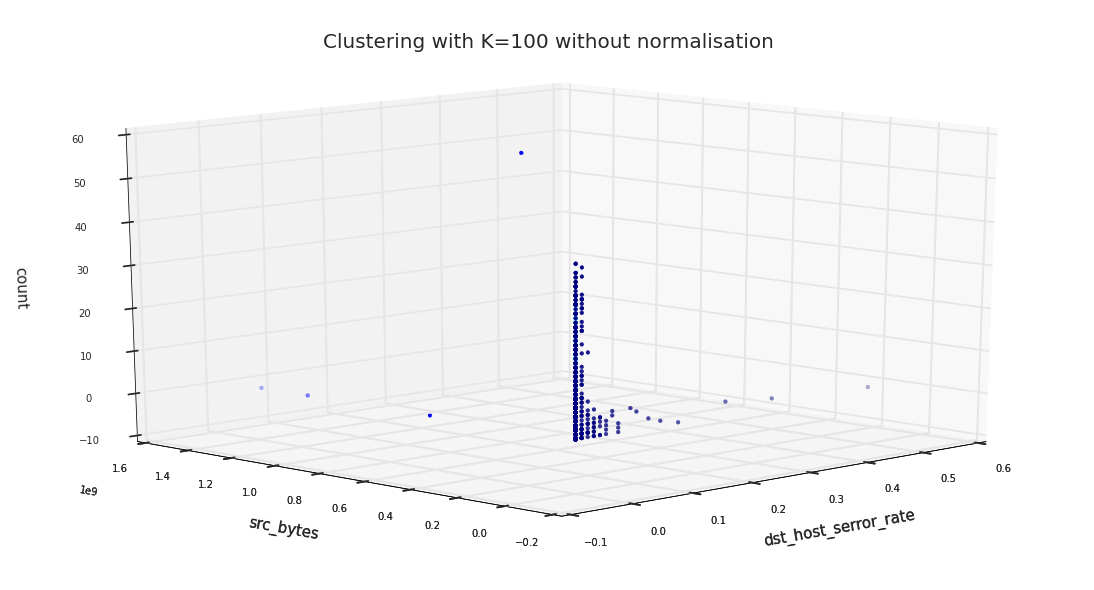

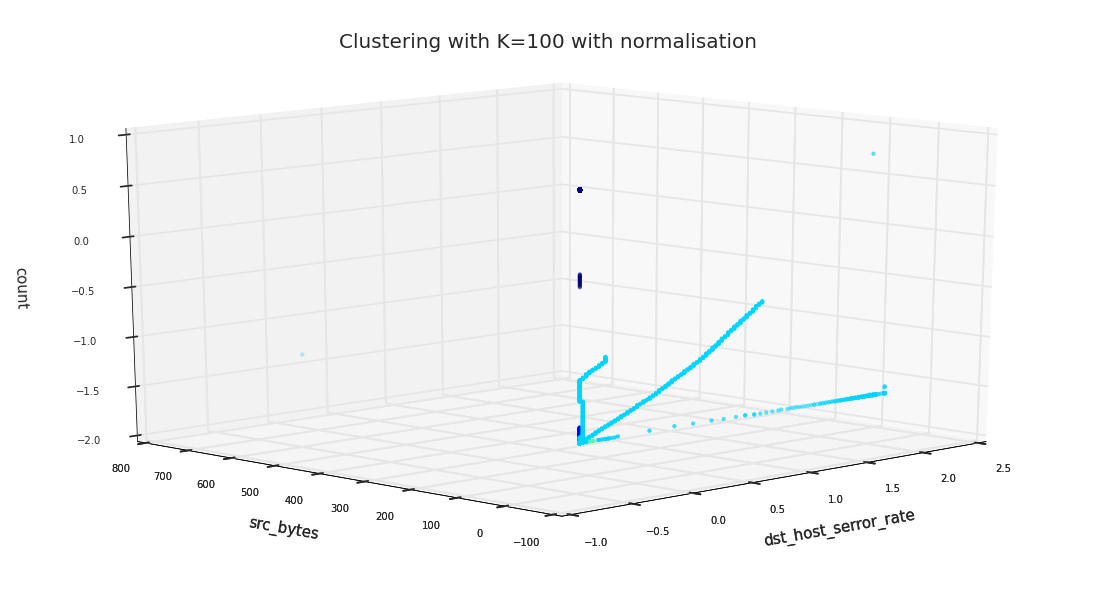

In [123]:
labels = ['dst_host_serror_rate' , 'src_bytes', 'count']
plot_clusters3D(points, top3features, "Clustering with K=100 without normalisation", labels)
plot_clusters3D(pointsNorm, top3features, "Clustering with K=100 with normalisation", labels)

<div class="alert alert-success">
Well, this is not as much informative as expected. Visualise this problem is a challenging task: 5 millions points with more than 30 dimensions and 100 clusters to plot is almost impossible. No interesting trends can be highlighted from these plot, except for the observation that, as expected, with normalized features, points are spread further from each other.
<br>
For completeness now we want to try to visualise plotting only the centroids reduced in 3 dimensions using a simple PCA trained on the 20% of the dataset.
</div>

In [124]:
data_local = data.take(1000000)
data_norm_local = normalizedData.take(1000000)

pca_data = decomposition.PCA(n_components=3).fit(data_local)
pca_data_norm = decomposition.PCA(n_components=3).fit(data_norm_local)

In [125]:
clusters = KMeans.train(data, 100, maxIterations=100, initializationMode="random")
clustersNorm = KMeans.train(normalizedData, 100, maxIterations=10, initializationMode="random")

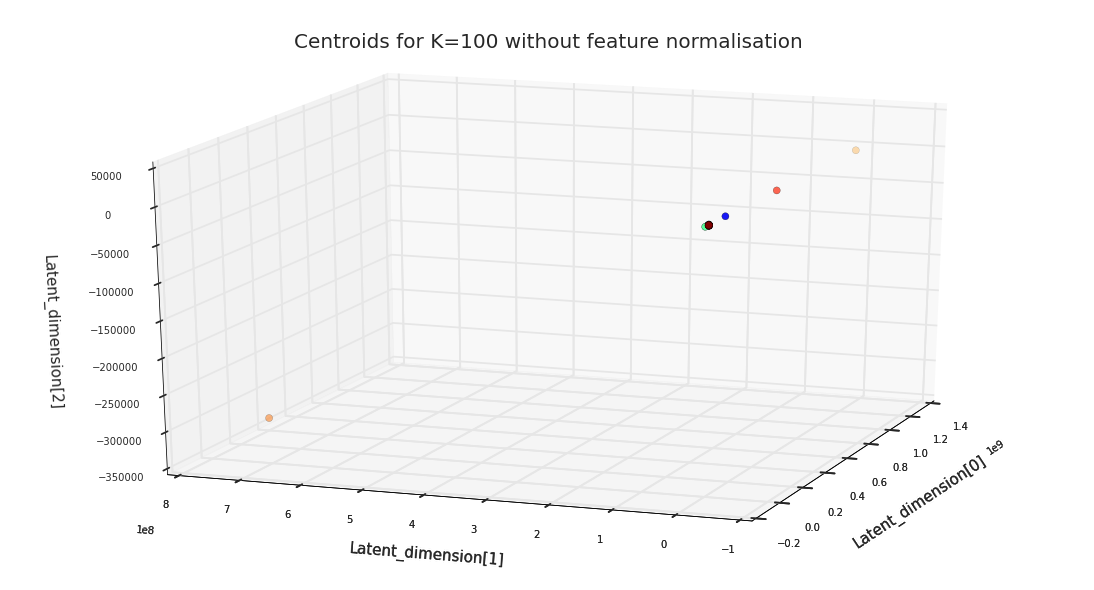

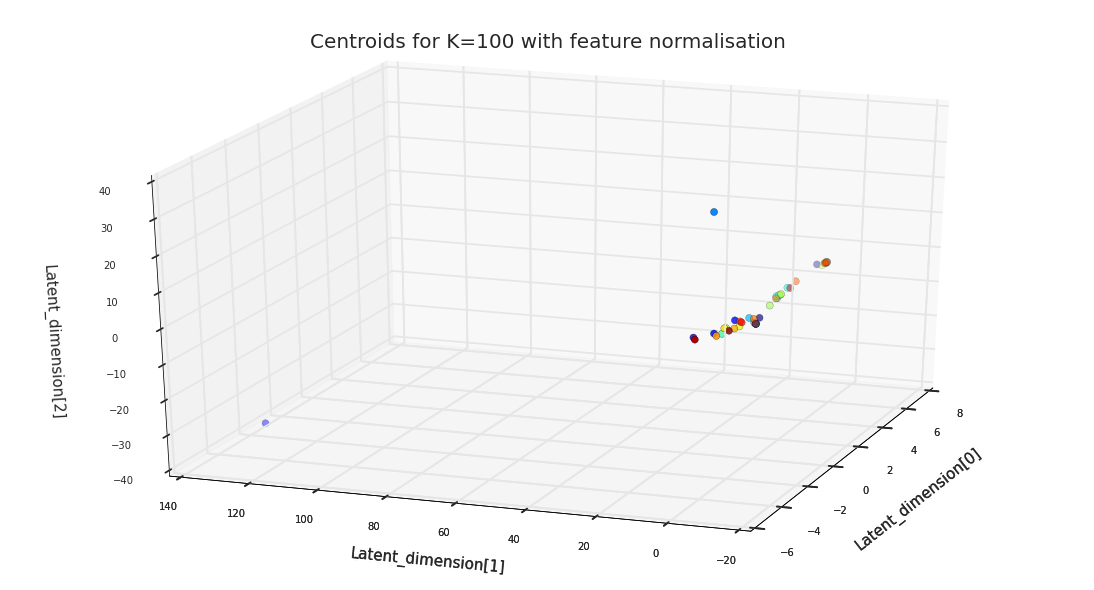

In [126]:
tmp = np.array(list(map(lambda x: pca_data.transform(x)[0], clusters.clusterCenters)))
fig = plt.figure(1, figsize=(15, 8))
plt.clf()
ax = Axes3D(fig, rect=[0, 0, 1, 1], elev=20, azim=200)
plt.cla()
colormap = cm.get_cmap('jet')
ax.scatter(tmp[:,0], tmp[:,1], tmp[:,2],c=range(len(tmp[:,0])), cmap=colormap, s=50)
plt.title('Centroids for K=100 without feature normalisation',fontsize=20)
ax.set_xlabel('Latent_dimension[0]', fontsize=15)
ax.set_ylabel('Latent_dimension[1]', fontsize=15)
ax.set_zlabel('Latent_dimension[2]', fontsize=15)
plt.show()

tmp = np.array(list(map(lambda x: pca_data_norm.transform(x)[0], clustersNorm.clusterCenters)))
fig = plt.figure(1, figsize=(15, 8))
plt.clf()
ax = Axes3D(fig, rect=[0, 0, 1, 1], elev=25, azim=200)
plt.cla()
ax.scatter(tmp[:,0], tmp[:,1], tmp[:,2], c=range(len(tmp[:,0])), cmap=colormap, s=50)
plt.title('Centroids for K=100 with feature normalisation',fontsize=20)
ax.set_xlabel('Latent_dimension[0]', fontsize=15)
ax.set_ylabel('Latent_dimension[1]', fontsize=15)
ax.set_zlabel('Latent_dimension[2]', fontsize=15)
plt.show()

<div class="alert alert-success">
Even here, is difficult to draw outcomes from this plot but, at least, we can appreciate different positions of the centroids and their distribution in this latent space.
</div>

## 2.3. Clustering using categorical features

### 2.3.1 Loading data

In the previous section, we ignored the categorical features of our data: this is not a good idea, since these categorical features can be important in providing useful information for clustering.
The problem is that K-means (or at least, the one we have developed and the one we use from MLLib) only work with data points in a metric space. Informally, this means that operations such as addition, subtraction and computing the mean of data points are trivial and well defined. For a more formal definition of what a metric space is, follow this [link](https://en.wikipedia.org/wiki/Metric_space#Definition).

What we will do next is to transform each categorical feature into one or more numerical features. This approach is very widespread: imagine for example you wanted to use K-means to cluster text data. Then, the idea is to transform text data in $d$-dimensional vectors, and a nice way to do it is to use [word2vec](http://deeplearning4j.org/word2vec). If you're interested, follow this link to a nice [blog post](http://bigdatasciencebootcamp.com/posts/Part_3/clustering_news.html) on the problem.

There are two approaches:

* **Approach 1**: mapping **one** categorical feature to **one** numerical feature. The values in each categorical feature are encoded into unique numbers of the new numerical feature. For example, ['VERY HOT','HOT', 'COOL', 'COLD', 'VERY COLD'] will be encoded into [0,1,2,3,4,5]. However, by using this method, we implicit assume that the value of 'VERY HOT' is smaller than 'HOT'... This is not generally true.

* **Approach 2**: mapping **one** categorical feature to **multiple** numerical features. Basically, a single variable with $n$ observations and $d$ distinct values, to $d$ binary variables with $n$ observations each. Each observation indicating the presence (1) or absence (0) of the $d^{th}$ binary variable. For example, ['house', 'car', 'tooth', 'car'] becomes 
```
[
[1,0,0,0],
[0,1,0,0],
[0,0,1,0],
[0,0,0,1],
]
```

We call the second approach "one-hot encoding". By using this approach, we keep the same role for all values of categorical features.



![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

#### Question 10

<div class="alert alert-info">

Calculate the number of distinct categorical features value (at index `1,2,3`). Then construct a new input data using one-hot encoding for these categorical features (don't throw away numerical features!).

</div>

```python
def parseLineWithHotEncoding(line):
    cols = line...
    # label is the last column
    label = ...
    
    vector = cols[0:-1]
    
    # the binary features that are encoded from the first categorical feature
    featureOfCol1 = ...
    # the binary features that are encoded from the second categorical feature
    featureOfCol2 = ...
    # the binary features that are encoded from the third categorical feature
    featureOfCol3 = ...
    
    # construct the new vector
    vector = ([vector[0]] + featureOfCol1 + featureOfCol2 + 
        featureOfCol3 + vector[4:])
    
    # convert each value from string to float
    vector = np.array(...)
    
    return (label, vector)

labelsAndData = raw_data.map(parseLine)

# we only need the data, not the label
data = labelsAndData.values().cache()


normalizedData = normalizeData(data).cache()
```

<div class="alert alert-success">

Let's see which values we can have for the categorical features and then count them.
</div>

In [15]:
valuesCol1 = raw_data.map(lambda line: line.split(",")[1]).distinct().collect()
valuesCol2 = raw_data.map(lambda line: line.split(",")[2]).distinct().collect()
valuesCol3 = raw_data.map(lambda line: line.split(",")[3]).distinct().collect()

In [16]:
print("- POSSIBLE TYPES OF PROTOCOLS")
print(valuesCol1)
print("\n- POSSIBLE TYPES OF SERVICES")
print(valuesCol2)
print("\n- POSSIBLE TYPES OF FLAGS")
print(valuesCol3)

- POSSIBLE TYPES OF PROTOCOLS
['udp', 'tcp', 'icmp']

- POSSIBLE TYPES OF SERVICES
['harvest', 'systat', 'other', 'kshell', 'http', 'remote_job', 'Z39_50', 'tftp_u', 'vmnet', 'discard', 'eco_i', 'printer', 'nnsp', 'sql_net', 'iso_tsap', 'urp_i', 'urh_i', 'bgp', 'ctf', 'netstat', 'mtp', 'ssh', 'efs', 'rje', 'shell', 'telnet', 'smtp', 'courier', 'echo', 'ntp_u', 'gopher', 'whois', 'pop_3', 'uucp_path', 'netbios_dgm', 'domain_u', 'finger', 'http_2784', 'sunrpc', 'daytime', 'pop_2', 'ftp_data', 'IRC', 'hostnames', 'nntp', 'login', 'csnet_ns', 'X11', 'supdup', 'pm_dump', 'http_8001', 'auth', 'uucp', 'ecr_i', 'time', 'name', 'ftp', 'ldap', 'private', 'exec', 'http_443', 'netbios_ns', 'domain', 'klogin', 'aol', 'imap4', 'tim_i', 'red_i', 'netbios_ssn', 'link']

- POSSIBLE TYPES OF FLAGS
['SH', 'OTH', 'S2', 'RSTO', 'S0', 'RSTR', 'S3', 'S1', 'RSTOS0', 'SF', 'REJ']


In [17]:
numValuesCol1 = len(valuesCol1)
numValuesCol2 = len(valuesCol2)
numValuesCol3 = len(valuesCol3)
print("NUMBER OF PROTOCOLS: ", numValuesCol1)
print("NUMBER OF SERVICES : ", numValuesCol2)
print("NUMBER OF FLAGS    : ", numValuesCol3)

NUMBER OF PROTOCOLS:  3
NUMBER OF SERVICES :  70
NUMBER OF FLAGS    :  11


In [18]:
def parseLineWithHotEncoding(line):
    cols = line.split(',')
    # label is the last column
    label = cols[-1]
    vector = cols[0:-1]

    featureCol1 = [0]*numValuesCol1
    featureCol1[valuesCol1.index(vector[1])] = 1

    featureCol2 = [0]*numValuesCol2
    featureCol2[valuesCol2.index(vector[2])] = 1

    featureCol3 = [0]*numValuesCol3
    featureCol3[valuesCol3.index(vector[3])] = 1

    vector = ([vector[0]] + featureCol1 + featureCol2 + featureCol3 + vector[4:])
    
    # convert each value from string to float
    vector = np.array(list(map(lambda x: float(x), vector)))

    return (label, vector)

In [19]:
labelsAndDataHot = raw_data.map(parseLineWithHotEncoding).cache()

# we only need the data, not the label
dataHot = labelsAndDataHot.values().cache()

<div class="alert alert-success">

From the previous 38 features we have now added 3 categorical features, but the first is mapped into 3 features, the second in 70 and the third in 11. We end up with 122 features.
</div>

In [20]:
print(len(dataHot.take(1)[0]))

122


In [21]:
normalizedDataHot = normalizeData(dataHot).cache();

[  7.23329737e+02   1.95166939e-01   4.85846633e-01   4.93805704e-01
   6.38978745e-04   1.46810340e-02   1.20879721e-01   1.45694133e-02
   3.33199295e-01   1.47987077e-02   1.48331398e-02   7.82585860e-04
   1.46601699e-02   1.47018684e-02   5.76561282e-02   1.46043865e-02
   1.45554005e-02   1.46532086e-02   1.46532086e-02   3.31164186e-02
   5.49662108e-03   1.46183523e-02   1.47641952e-02   1.46810340e-02
   1.48193766e-02   1.48124902e-02   1.45834127e-02   1.47780099e-02
   1.46462440e-02   2.95359841e-02   1.39006035e-01   1.44357419e-02
   1.47018684e-02   2.79621737e-02   1.48262598e-02   1.47987077e-02
   2.01060105e-02   1.46879821e-02   1.46532086e-02   1.07967013e-01
   3.74806345e-02   4.51826249e-04   1.46810340e-02   1.46810340e-02
   1.46740826e-02   9.07697351e-02   1.03125785e-02   1.46392761e-02
   1.47018684e-02   1.46043865e-02   1.46462440e-02   5.24967481e-03
   1.47088067e-02   1.01031380e-03   6.38978745e-04   2.62668702e-02
   1.45764147e-02   4.94494884e-01

<div class="alert alert-success">
One of the main assumptions made was that data instances having the same attack type (or if both of them are normal) will be close together under some metric. Therefore, finding or constructing an appropriate metric is essential for clustering.
</div>

### 2.3.2. Building models

![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

#### Question 11
<div class="alert alert-info">

Using the new data, cluster the connections with different values of $k \in [80,90,100,110,120,130,140,150,160]$.
Evaluate the results and choose the best value of $k$ as previous questions.

</div>

```python
scores = list(...)
plt....
```

In [39]:
range3 = range(80, 161, 10)

scoresNormHot = []

runs = 5
for k in range3:
    total_score = []
    for i in range(runs):
        t0 = time()
        s = clusteringScore(normalizedDataHot, k)
        t1 = time()
        total_score.append(s)
        print("Number of clusters:  %d \t Score: %.2f \t Execution Time: %.2f s" % (k, s, (t1-t0)))
    mean = np.array(total_score).mean()
    var = np.array(total_score).var()
    print('Number of clusters:  %d \t Mean: %.2f \t Var: %.2f' % (k, mean, var))
    scoresNormHot.append((mean, var))

Number of clusters:  80 	 Score: 69.64 	 Execution Time: 27.21 s
Number of clusters:  80 	 Score: 71.52 	 Execution Time: 26.92 s
Number of clusters:  80 	 Score: 67.56 	 Execution Time: 29.29 s
Number of clusters:  80 	 Score: 75.36 	 Execution Time: 24.98 s
Number of clusters:  80 	 Score: 74.09 	 Execution Time: 27.19 s
Number of clusters:  80 	 Mean: 71.63 	 Var: 8.11
Number of clusters:  90 	 Score: 63.72 	 Execution Time: 25.44 s
Number of clusters:  90 	 Score: 66.11 	 Execution Time: 24.87 s
Number of clusters:  90 	 Score: 67.64 	 Execution Time: 24.37 s
Number of clusters:  90 	 Score: 65.24 	 Execution Time: 27.45 s
Number of clusters:  90 	 Score: 64.56 	 Execution Time: 27.27 s
Number of clusters:  90 	 Mean: 65.45 	 Var: 1.82
Number of clusters:  100 	 Score: 68.37 	 Execution Time: 26.99 s
Number of clusters:  100 	 Score: 67.07 	 Execution Time: 25.96 s
Number of clusters:  100 	 Score: 66.00 	 Execution Time: 26.84 s
Number of clusters:  100 	 Score: 62.43 	 Execution 

array([ 71.63402293,  65.45443836,  67.28340436,  63.73176547,
        60.39629078,  59.47487698,  56.81672411,  55.8148239 ,  54.40057902])


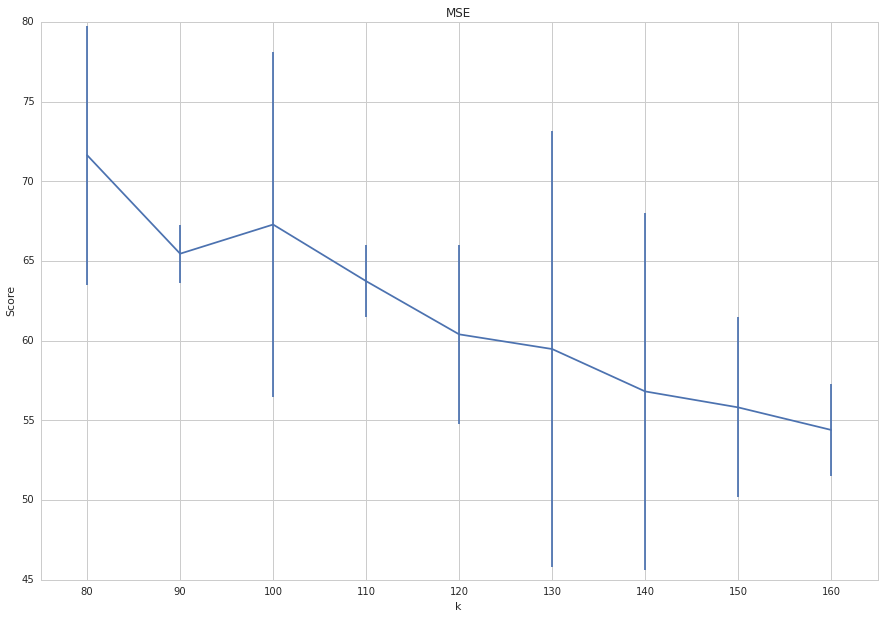

In [40]:
pprint(np.array(scoresNormHot)[:,0])
plt.figure(figsize=[15, 10])
plt.title('MSE')
plt.xlabel("k")
plt.ylabel("Score")
plt.errorbar(range3, np.array(scoresNormHot)[:,0], yerr=1*np.array(scoresNormHot)[:,1])
plt.xticks(range3,[k for k in range3])
plt.xlim(75,165)
plt.show()

<div class="alert alert-success">
After training 5 times, we see the decreasing trend of the MSE, hence we conclude the best value is 160.
</div>

## 2.4. Anomaly detection
When we have a new connection data (e.g., one that we never saw before), we simply find the closest cluster for it, and use this information as a proxy to indicate whether the data point is anomalous or not. A simple approach to decide when there is an anomaly or not, amounts to measuring the new data point’s distance to its nearest centroid. If this distance exceeds some thresholds, it is anomalous.

![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

#### Question 12
<div class="alert alert-info">

Build your model with the best value of $k$ in your opinion. Then, detect the anomalous connections in our data. Plot and discuss your result.

</div>

<div class="label label-success">HINT</div> The threshold has strong impact on the result. Be careful when choosing it! A simple way to choose the threshold's value is picking up a distance of a data point from among known data. For example, the 100th-farthest data point distance can be an option.

In [40]:
best_k = 160
clusters = KMeans.train(normalizedDataHot, best_k, maxIterations=10, initializationMode="random")

In [36]:
def distance(clusters, point):
    closest_center = clusters.centers[clusters.predict(point)]
    return euclidean_distance(closest_center, point)

In [43]:
topAnomalies = normalizedDataHot.map(lambda point: (point, distance(clusters, point)))\
                                .takeOrdered(100, lambda x: -x[1])

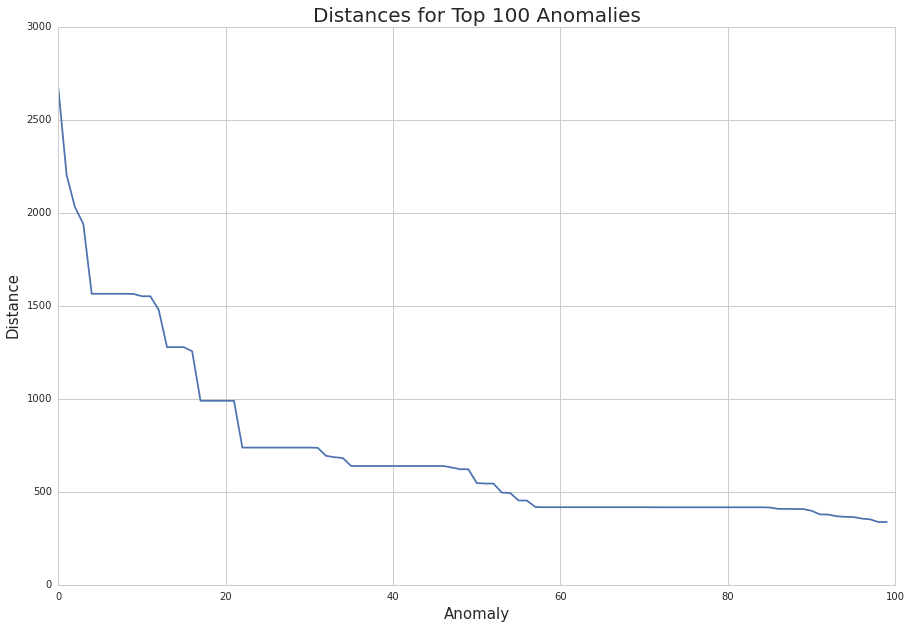

In [44]:
plt.figure(figsize=[15, 10])
plt.title('Distances for Top 100 Anomalies', fontsize=20)
plt.xlabel("Anomaly", fontsize=15)
plt.ylabel("Distance", fontsize=15)
plt.plot([anomaly[1] for anomaly in topAnomalies])
plt.show()

In [71]:
for i in range(6,40):
    print("Anomaly # %d, distance %.2f" % (i+1, topAnomalies[i][1]))

Anomaly # 7, distance 1564.70
Anomaly # 8, distance 1564.70
Anomaly # 9, distance 1564.66
Anomaly # 10, distance 1563.77
Anomaly # 11, distance 1551.38
Anomaly # 12, distance 1551.38
Anomaly # 13, distance 1479.36
Anomaly # 14, distance 1277.78
Anomaly # 15, distance 1277.78
Anomaly # 16, distance 1277.78
Anomaly # 17, distance 1255.84
Anomaly # 18, distance 989.32
Anomaly # 19, distance 989.28
Anomaly # 20, distance 989.27
Anomaly # 21, distance 989.27
Anomaly # 22, distance 989.27
Anomaly # 23, distance 737.70
Anomaly # 24, distance 737.70
Anomaly # 25, distance 737.70
Anomaly # 26, distance 737.70
Anomaly # 27, distance 737.70
Anomaly # 28, distance 737.70
Anomaly # 29, distance 737.70
Anomaly # 30, distance 737.70
Anomaly # 31, distance 737.70
Anomaly # 32, distance 736.68
Anomaly # 33, distance 693.36
Anomaly # 34, distance 685.96
Anomaly # 35, distance 681.60
Anomaly # 36, distance 638.86
Anomaly # 37, distance 638.86
Anomaly # 38, distance 638.86
Anomaly # 39, distance 638.86
An

<div class="alert alert-success">
From this graph and from the printed values, we discover some plateaus. The one at distance 737.7, around anomaly # 25, seems to be the last one before the beginning of a steep slope and we could consider this as a threshold, but we don't know what happens after the 100th.

To be sure about this analysis, we plot now a wider range in the number of anomalies. 
</div>

In [45]:
topAnomalies = normalizedDataHot.map(lambda point: (point, distance(clusters, point)))\
                                .takeOrdered(1000, lambda x: -x[1])

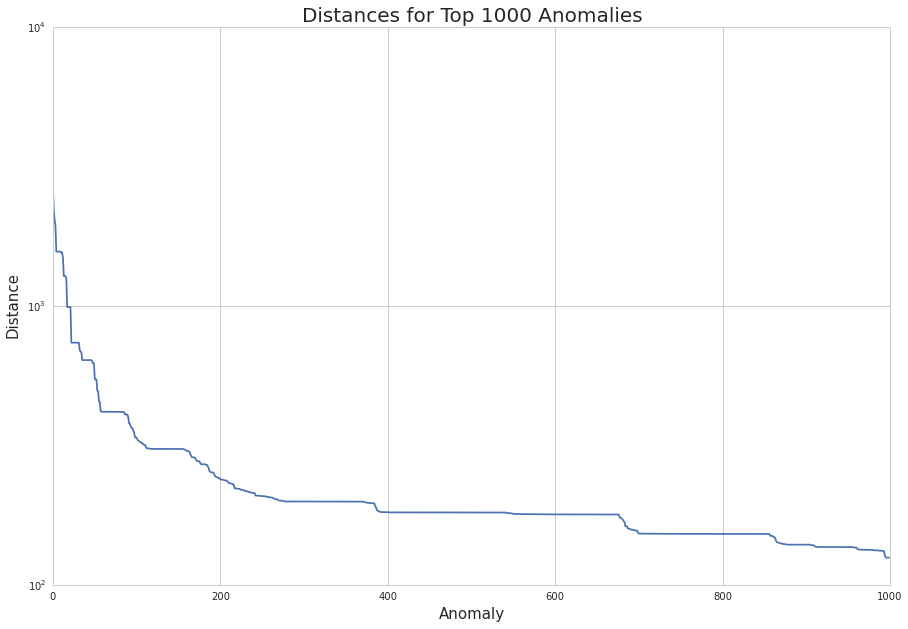

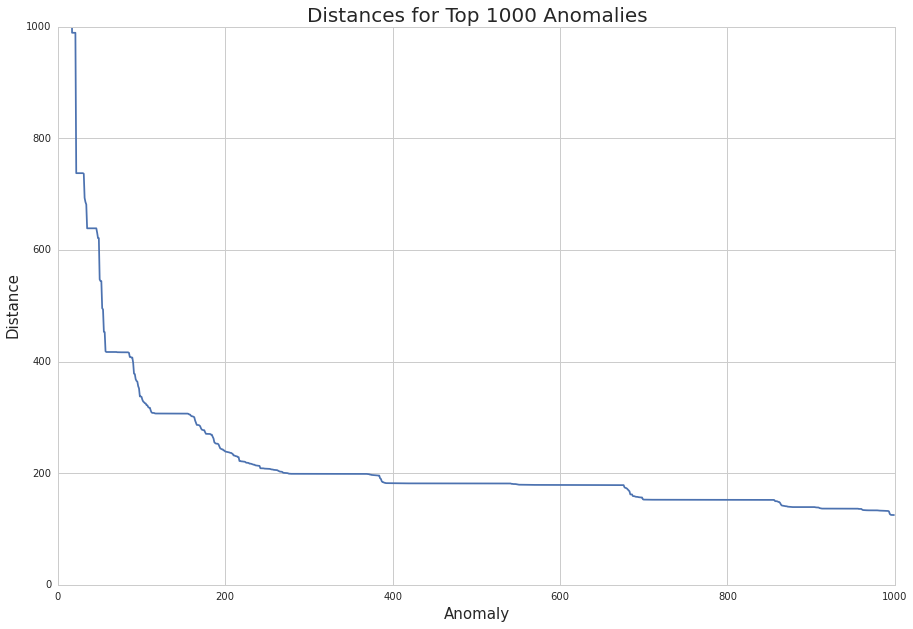

In [72]:
plt.figure(figsize=[15, 10])
plt.title('Distances for Top 1000 Anomalies', fontsize=20)
plt.xlabel("Anomaly", fontsize=15)
plt.ylabel("Distance", fontsize=15)
plt.semilogy([anomaly[1] for anomaly in topAnomalies])

plt.show()
plt.figure(figsize=[15, 10])
plt.title('Distances for Top 1000 Anomalies', fontsize=20)
plt.xlabel("Anomaly", fontsize=15)
plt.ylabel("Distance", fontsize=15)
plt.plot([anomaly[1] for anomaly in topAnomalies])
plt.ylim(0, 1000)
plt.show()

In [90]:
for i in range(55,70):
    print("Anomaly # %d, distance %.2f" % (i+1, topAnomalies[i][1]))
print("...")

for i in range(110,125):
    print("Anomaly # %d, distance %.2f" % (i+1, topAnomalies[i][1]))
print("...")
for i in range(270,295):
    print("Anomaly # %d, distance %.2f" % (i+1, topAnomalies[i][1]))

Anomaly # 56, distance 453.48
Anomaly # 57, distance 452.81
Anomaly # 58, distance 418.30
Anomaly # 59, distance 417.21
Anomaly # 60, distance 417.21
Anomaly # 61, distance 417.21
Anomaly # 62, distance 417.21
Anomaly # 63, distance 417.21
Anomaly # 64, distance 417.21
Anomaly # 65, distance 417.21
Anomaly # 66, distance 417.21
Anomaly # 67, distance 417.21
Anomaly # 68, distance 417.21
Anomaly # 69, distance 417.21
Anomaly # 70, distance 417.21
...
Anomaly # 111, distance 317.24
Anomaly # 112, distance 312.27
Anomaly # 113, distance 308.86
Anomaly # 114, distance 308.07
Anomaly # 115, distance 308.06
Anomaly # 116, distance 307.93
Anomaly # 117, distance 307.20
Anomaly # 118, distance 306.97
Anomaly # 119, distance 306.97
Anomaly # 120, distance 306.96
Anomaly # 121, distance 306.96
Anomaly # 122, distance 306.96
Anomaly # 123, distance 306.96
Anomaly # 124, distance 306.96
Anomaly # 125, distance 306.96
...
Anomaly # 271, distance 200.63
Anomaly # 272, distance 200.52
Anomaly # 273, 

<div class="alert alert-success">
From these plots we have a better understanding of the distribution of the anomalies distances. We still see 3 main plateaus, but now we think it's more appropriate to choose a threshold around 417.21, 306.96 or 198.91. These values represent the end of the plateaus. If we want to be more suspicious, we should choose the last threshold, but since the first plateau presents a steeper slope on its left side (looking at the plot above), we will chose 417.22. 
</div>

In [91]:
threshold = 417.22
detected1 = [anomaly for anomaly in topAnomalies if anomaly[1] > threshold]
print(len(detected1))

58


In [92]:
threshold = 306.97
detected2 = [anomaly for anomaly in topAnomalies if anomaly[1] > threshold]
print(len(detected2))

118


<div class="alert alert-success">
By selecting 306.97 as a threshold we would get an increment in the anomalies by a factor of 2.
<br><br>
What if we extend our region of analysis by an order of magnitude?
</div>

In [42]:
clusters = KMeans.train(normalizedDataHot, best_k, maxIterations=10, initializationMode="random")

In [48]:
topAnomalies = normalizedDataHot.map(lambda point: (point, distance(clusters, point)))\
                                .takeOrdered(10000, lambda x: -x[1])

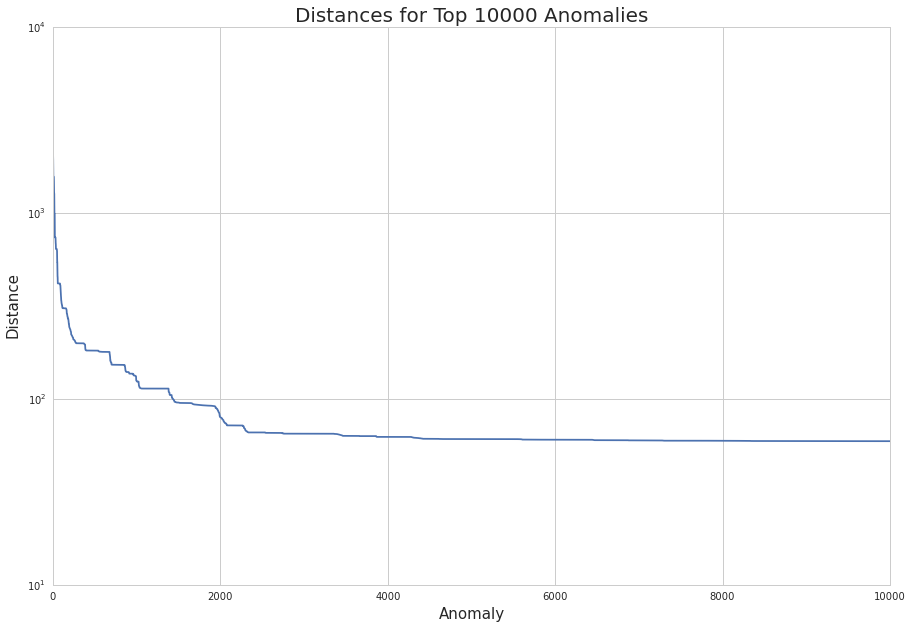

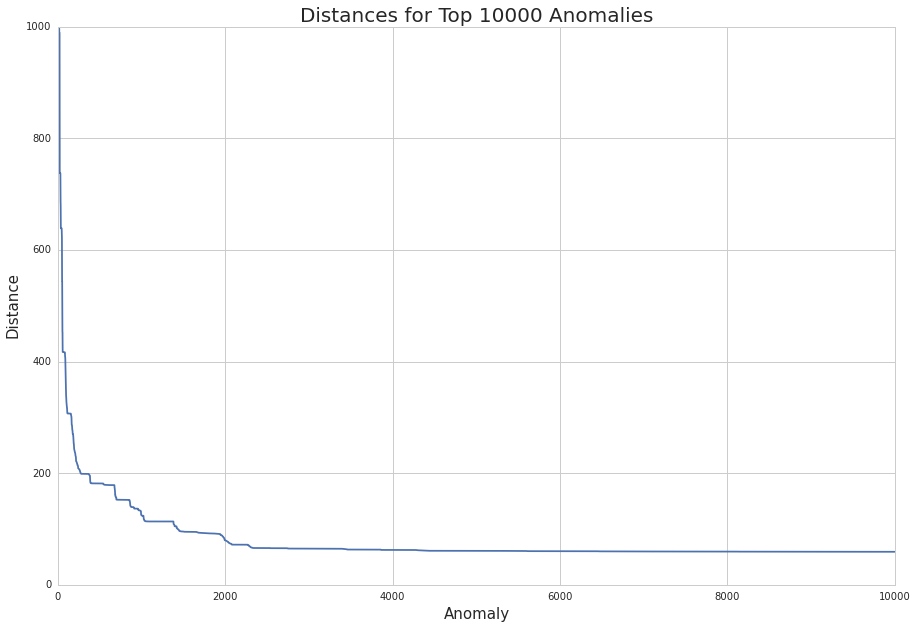

In [94]:
plt.figure(figsize=[15, 10])
plt.title('Distances for Top 10000 Anomalies', fontsize=20)
plt.xlabel("Anomaly", fontsize=15)
plt.ylabel("Distance", fontsize=15)
plt.semilogy([anomaly[1] for anomaly in topAnomalies])

plt.show()
plt.figure(figsize=[15, 10])
plt.title('Distances for Top 10000 Anomalies', fontsize=20)
plt.xlabel("Anomaly", fontsize=15)
plt.ylabel("Distance", fontsize=15)
plt.plot([anomaly[1] for anomaly in topAnomalies])
plt.ylim(0, 1000)
plt.show()

In [101]:
for i in range(2100,2120):
    print("Anomaly # %d, distance %.2f" % (i+1, topAnomalies[i][1]))
print("...")
for i in range(2750,2770):
    print("Anomaly # %d, distance %.2f" % (i+1, topAnomalies[i][1]))


Anomaly # 2101, distance 71.93
Anomaly # 2102, distance 71.93
Anomaly # 2103, distance 71.93
Anomaly # 2104, distance 71.93
Anomaly # 2105, distance 71.93
Anomaly # 2106, distance 71.93
Anomaly # 2107, distance 71.93
Anomaly # 2108, distance 71.93
Anomaly # 2109, distance 71.93
Anomaly # 2110, distance 71.93
Anomaly # 2111, distance 71.93
Anomaly # 2112, distance 71.93
Anomaly # 2113, distance 71.93
Anomaly # 2114, distance 71.93
Anomaly # 2115, distance 71.93
Anomaly # 2116, distance 71.93
Anomaly # 2117, distance 71.93
Anomaly # 2118, distance 71.93
Anomaly # 2119, distance 71.93
Anomaly # 2120, distance 71.93
...
Anomaly # 2751, distance 65.20
Anomaly # 2752, distance 65.16
Anomaly # 2753, distance 65.15
Anomaly # 2754, distance 65.15
Anomaly # 2755, distance 65.15
Anomaly # 2756, distance 64.99
Anomaly # 2757, distance 64.96
Anomaly # 2758, distance 64.95
Anomaly # 2759, distance 64.95
Anomaly # 2760, distance 64.95
Anomaly # 2761, distance 64.95
Anomaly # 2762, distance 64.95
Anom

<div class="alert alert-success">
This result makes our threshold choice more difficult. On a data set of around 5 million connections, how many anomalies should we expect? This depends on what kind of data we have. The KDD99 dataset contains a wide variety of intrusions simulated in a military network environment, but we have no clue about what ratio between standard connections and anomaly connection we should expect. From this last graph it seems also reasonable to choose a value around 65. In this case we would get many more anomalies.
</div>

In [102]:
threshold = 65
detected3 = [anomaly for anomaly in topAnomalies if anomaly[1] > threshold]
print(len(detected3))

2755


In [22]:
def normalizeLabelsAndDataHot(labelsAndDataHot):
    # calculate means
    dataHot = labelsAndDataHot.values()
    means = dataHot.mean()    

    # calculate standard deviation of each feature
    stdevs = dataHot.stdev()
    stdevs[stdevs==0] = 1
    
    def normalize(labelAndPoint):
        return (labelAndPoint[0], (labelAndPoint[1] - means) / stdevs)

    return labelsAndDataHot.map(normalize)

In [82]:
ttt = normalizeLabelsAndDataHot(labelsAndDataHot).cache()

In [52]:
labelsPointsAnomalies = ttt.map(lambda labelPoint: (labelPoint[0], labelPoint[1], distance(clusters, labelPoint[1])))\
                                .takeOrdered(100, lambda x: -x[2])

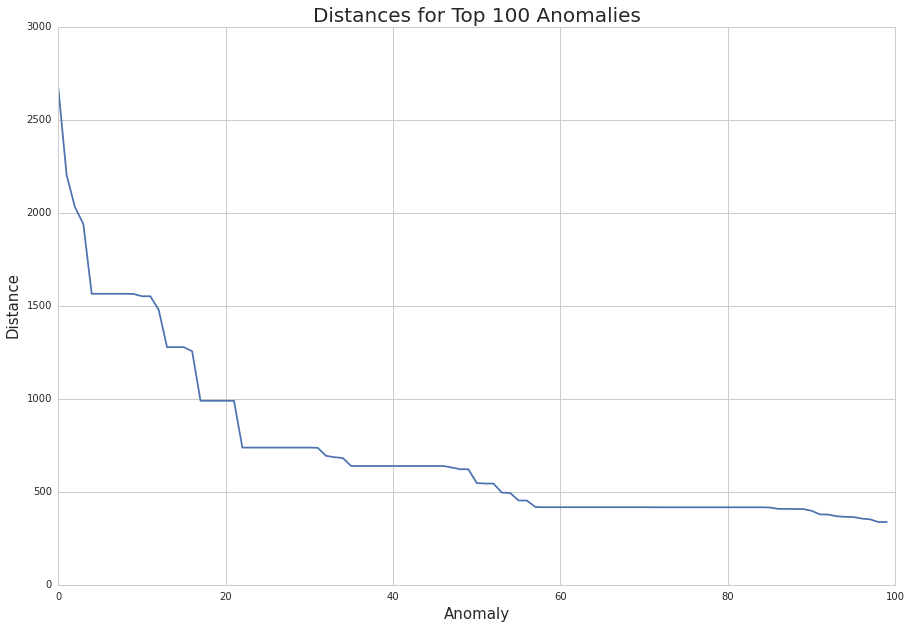

In [139]:
plt.figure(figsize=[15, 10])
plt.title('Distances for Top 100 Anomalies', fontsize=20)
plt.xlabel("Anomaly", fontsize=15)
plt.ylabel("Distance", fontsize=15)
plt.plot([anomaly[2] for anomaly in labelsPointsAnomalies])
plt.show()

<div class="alert alert-success">
Here, we show the labels of the points we consider anomalies.
</div>

In [100]:
bClusters = sc.broadcast(clusters)
threashold = 306.97

anomalyLabels = ttt.map(lambda labelPoint: (labelPoint[0], labelPoint[1], distance(bClusters.value, labelPoint[1])))\
                   .map(lambda x : (x[0], x[2]))\
                   .filter(lambda x : x[1] > threashold)\
                   .sortBy(lambda x : -x[1])\
                   .map(lambda x: (x[0],1))\
                   .reduceByKey(lambda x,y:x+y)\
                   .cache()

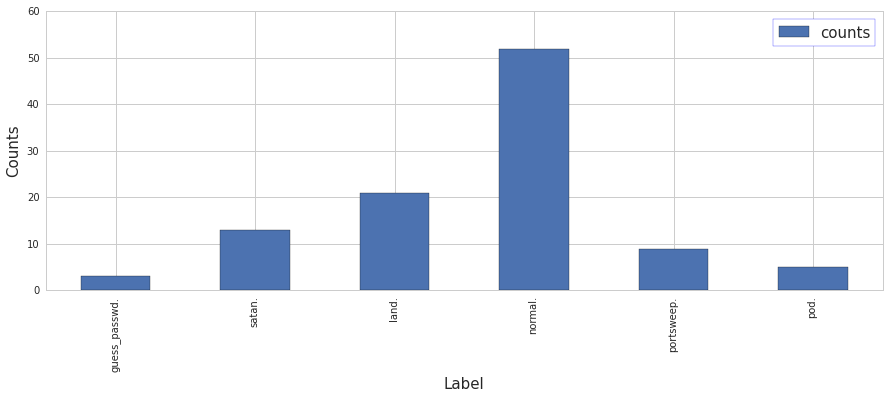

In [102]:
tmp_df = pd.DataFrame(anomalyLabels.collect(), columns=['label', 'counts'])
fig, axes = plt.subplots(1,1, figsize=(15,5), sharex=True)
tmp_df.plot(kind='bar', x=tmp_df.label, ax=axes)
axes.legend(fontsize=15, frameon=True).get_frame().set_edgecolor('blue')  
axes.set_ylabel('Counts', fontsize=15)
axes.set_xlabel('Label', fontsize=15)
plt.show()

<div class="alert alert-success">
Apparently, we have a lot of normal connections which are considered anomalies. This tells us that we are indeed detecting anomalies in our dataset, as they can be associated to any type of connection, not only attacks.

</div>

#### Question 13
<div class="alert alert-info">

Try other methods to find the best value for $k$ such as `silhouette`, `entropy`... In particular, with this data, you can take advantage of predefined labels to calculate the quality of model using entropy... However, we suggest you to try with `silhouette`. It's more general and can work with any dataset (with and without predefined labels).

<br><br>

Here are some additional information about the metrics we suggest to use:
<br>
- [Silhouette](https://en.wikipedia.org/wiki/Silhouette_(clustering)
<br>
- [Hack approach to Silhouette](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html)
<br>

- [Entropy](http://scikit-learn.org/stable/modules/clustering.html) [Lookup for entropy]
<br>
<br>

<div class="label label-danger">Note</div> you are free to play with any relevant evaluation metric you think appropriate for your work!
</div>

<div class="alert alert-success">
We decided to focus on the `silhouette` and to implement a distributed program for computing it. The popular method of silhouette coefficients combines both `cohesion` and `separation`.
The following steps explain how to compute this coefficient for an individual point $i$:
<ol>
<li>For the $i^{th}$ object, calculate its average distance to all other objects on its cluster and call this value $a_i$</li>
<li>For the $i^{th}$ object and any cluster not containing the object, calculate the object's average distance to all the objects in the given cluster and find the minimum value with respect to all clusters; call this value $b_i$ </li>
<li>For the $i^{th}$ object, the silhouette coefficient is 
$$
s_i = \dfrac{b_i - a_i}{max(a_i, b_i)}
$$
</li>
</ol>
<br>
We want this value to be positive and as close to 1 as possible ($a_i$ close to 0).
<br><br>
Unfortunately, though, a simple complexity evaluation ($O(n^2)$, where $n$ is the number of points) suggests us that this definition cannot be applicable on a big dataset, like the one we are working on. 
<br><br>
For this reason, we now want to try to optimize by reducing the number of computations needed for computing the average silhouette of a model. As a first step, we now investigate how many distinct point there are in each cluster, with the ambition of avoiding recomputing the coefficient for the same points. 
</div>

In [16]:
def train_and_predict(data, k_best):
    clusters = KMeans.train(data, k_best, maxIterations=100, initializationMode="random")
    dataWithClusterNumber = data.map(lambda x : (x, clusters.predict(x))).cache()
    return (dataWithClusterNumber, clusters)    

In [17]:
dataHotNormWithClusterNumber, clusters = train_and_predict(normalizedDataHot, 160)

In [144]:
pointsPerCluster = []
for i in range(clusters.k):
    totalPoints =  dataHotNormWithClusterNumber.filter(lambda x:x[1]==i).count()

    uniquePoints = dataHotNormWithClusterNumber.filter(lambda x:x[1]==i)\
                                               .map(lambda x: tuple(x[0].tolist()) )\
                                               .distinct().count()
    pointsPerCluster.append((totalPoints, uniquePoints))
    
    print('K='+str(i)+'\tTotal: ',totalPoints,'\tUnique points:',uniquePoints,\
          '\tRatio: %.4f'%(uniquePoints/totalPoints) )

K=0	Total:  1542 	Unique points: 1518 	Ratio: 0.9844
K=1	Total:  3380 	Unique points: 3331 	Ratio: 0.9855
K=2	Total:  2087 	Unique points: 1919 	Ratio: 0.9195
K=3	Total:  43293 	Unique points: 19273 	Ratio: 0.4452
K=4	Total:  519 	Unique points: 519 	Ratio: 1.0000
K=5	Total:  3165 	Unique points: 566 	Ratio: 0.1788
K=6	Total:  3200 	Unique points: 3116 	Ratio: 0.9738
K=7	Total:  2276 	Unique points: 1139 	Ratio: 0.5004
K=8	Total:  3447 	Unique points: 504 	Ratio: 0.1462
K=9	Total:  4584 	Unique points: 4226 	Ratio: 0.9219
K=10	Total:  150990 	Unique points: 149906 	Ratio: 0.9928
K=11	Total:  344884 	Unique points: 479 	Ratio: 0.0014
K=12	Total:  6912 	Unique points: 6619 	Ratio: 0.9576
K=13	Total:  2077 	Unique points: 2006 	Ratio: 0.9658
K=14	Total:  5385 	Unique points: 2696 	Ratio: 0.5006
K=15	Total:  12197 	Unique points: 1836 	Ratio: 0.1505
K=16	Total:  2964 	Unique points: 2861 	Ratio: 0.9652
K=17	Total:  19510 	Unique points: 13708 	Ratio: 0.7026
K=18	Total:  23223 	Unique point

<div class="alert alert-success">
Unfortunately, this road is not feasible. Except for cluster 20, all the others contain a lot of unique points. For this reason, we decided not to proceed with this simplification and to try something else.
<br><br>
Let's start from scratch with the definition of centroid and silhouette. The centroid $\mathbf{C}$ of a set of point $\mathbf{x}_i$ is defined as follows:
<br><br>
$$
\mathbf{C} = \dfrac{1}{N}\sum_{i=0}^{N-1}\mathbf{x}_i
$$
<br>
In the definition of silhouette, $a_i$ is the average distance to all the points in the cluster where $\mathbf{x}_i$ belongs:
<br><br>
$$
a_i = \dfrac{1}{N-1}\sum_{j=0}^{N-1} d(\mathbf{x}_i, \mathbf{x}_j) = 
      \dfrac{1}{N-1}\sum_{j=0}^{N-1} \left\| \mathbf{x}_i - \mathbf{x}_j \right\|
$$
<br>
Starting from this definition we can maximize using the triangle inequality of norms:
<br><br>
$$
a_i = \dfrac{1}{N-1}\sum_{j=0}^{N-1} \left\| \mathbf{x}_i - \mathbf{x}_j \right\|
    \ge \dfrac{1}{N-1} \left\| \sum_{j=0}^{N-1} (\mathbf{x}_i - \mathbf{x}_j) \right\|
    = \left\| \mathbf{x}_i - \dfrac{1}{N-1} \sum_{j=0}^{N-1}\mathbf{x}_j\right\|
$$
$$
 = \left\| \mathbf{x}_i - \dfrac{N}{N-1}\dfrac{1}{N} \sum_{j=0}^{N-1}\mathbf{x}_j \right\|
 = \left\| \mathbf{x}_i - \dfrac{N}{N-1} \mathbf{C}\right\| = d\left(\mathbf{x}_i, \dfrac{N}{N-1}\mathbf{C}\right) \approx d\left(\mathbf{x}_i, \mathbf{C}\right)
$$
<br>
With a little bit of mathematical formalism, we demonstrated that we can approximate $a_i$ with the distance to its cluster.
<br><br>
$$
a_i \ge \tilde A_i = d\left(\mathbf{x}_i, \mathbf{C}\right)
$$
<br>
Formally $b_i$ is defined as follows:
<br><br>
$$
b_i = min_k \left\{\left. \dfrac{1}{N_k}\sum_{\xi=0}^{N_k-1}d\left(\mathbf{x}_i,\mathbf{x}_\xi\right) \right\vert k=0,\dots,K-1, k\neq k^* \right\}
$$
<br>
but we can use the same maximization also for $b_i$ obtaining 
<br><br>
$$
b_i \ge \tilde B_i = min_k \left\{ d\left(\mathbf{x}_i, \mathbf{C}_k\right) \right\}
$$
<br>
Defining the new silhouette as
<br><br>
$$
s_i \ge \tilde S_i = \dfrac{\tilde B_i - \tilde A_i}{max(\tilde B_i, \tilde A_i)}
$$
<br>
we can still find the best k for maximize the silhouette.
<br><br>
<div class="label label-warning">Note:</div> we are very proud of this result because we formally demonstrate that distances from centroids can be used in place of the average distances to all the points in a cluster. This reduces the complexity of the silhouette from $O(n^2)$ to $O(nK)$, nevertheless this silhouette can be still used for maximization in model selection. 
<br><br>
<div class="label label-danger">Disclaimer:</div> we didn't find any approximation like this one in the literature.
</div>

In [31]:
def compute_min_distance_to_centroids(centroids, point, pointLabel):
    """
        compute_min_distance_to_centroids(centroids, point, pointLabel)
        
        Compute all the distance between a point p and all the centroids except for the one 
        in which p is assigned.
        Args:
            centroids (list): List of all centroids
            point (np.array): Point to be consider 
            pointLabel (int): Cluster identifier for the point
        Returns: 
            np.array: The distance to the nearest centroid
    ----------------------------------------------------------------------------------------------------------------
    """
    l = []
    for i in range(len(centroids)):
        if i != pointLabel:
            l.append(euclidean_distance(centroids[i], point))
    return np.min(np.array(l))

def compute_approx_silhouette(centroids, dataWithClusterNumber):
    """
        compute_approx_silhouette(centroids, dataWithClusterNumber)
        
        Compute the approximate Silhouette value of a cluster assignment.
        Args:
            centroids (list<np.array>): List of all centroids in numpy format
            dataWithClusterNumber (RDD): RDD with points and assignments in the format (<point>, <cluster_number>)
        Returns:
            float: Average Silhouette for all the points in the dataset
            RDD: RDD with all Silhouettes for all the points in the format (<point>, <cluster_number>, <silhouette>)
    ----------------------------------------------------------------------------------------------------------------
    """
    bCentroids = sc.broadcast(centroids)
    s_RDD = dataWithClusterNumber.map(lambda x:(x[0], \
                                                x[1], \
                                                euclidean_distance(x[0], bCentroids.value[x[1]]),\
                                                compute_min_distance_to_centroids(bCentroids.value, x[0], x[1])))\
                                  .map(lambda x:(x[0], \
                                                 x[1], \
                                                 x[2], \
                                                 x[3], \
                                                 (x[3]-x[2])/np.max(np.array([x[2], x[3]])))).cache()
    
    #num = s_RDD.map(lambda x:x[4]).cache().reduce(lambda x,y: x+y)
    #den = s_RDD.map(lambda x:x[4]).count()
    #s_avg = num/den
     
    return s_RDD.map(lambda x:x[4]).mean(), s_RDD.map(lambda x: (x[0], x[1], x[4]))


def plot_silhouette(s_RDD, s_avg, total_k):
    """
        plot_silhouette(s_RDD, s_avg, total_k)
        
        Plot the Silhouette graph of a given cluster assignment.
        Args:
            s_RDD (RDD): RDD with Silhouettes for all the points in the format
                         (<point>, <cluster_number>, <silhouette>)
            s_avg (float): Average Silhouette of a given cluster assignment
            total_k (int): Total number of not-empty clusters
        Return:
            None
        Note:
            Inspired by scikit-learn documentation 
            (http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html)
    ----------------------------------------------------------------------------------------------------------------
    """
    
    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches([15, total_k/2*3/4])
    ax1.set_xlim([-0.1, 1])
    y_lower = 10

    tmp = s_RDD.map(lambda x:(x[1],x[2])).sortBy(lambda x:x[1]).cache()

    for i in range(total_k):
        print(i, end='')
        s_i = tmp.filter(lambda x:x[0]==i).map(lambda x:x[1]).sample(False, 0.5).collect()
        print('.', end=' ')
        s_i = np.array(s_i)

        size_cluster_i = s_i.shape[0]

        y_upper = y_lower + size_cluster_i

        color = cm.spectral(float(i) / total_k)
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, s_i,
                          facecolor=color, edgecolor=color, alpha=0.7)

        if i % 5 == 0:
            ax1.text(-0.05, (y_lower + y_upper) / 2, str(i))


        y_lower = y_upper + 10 

    ax1.set_title("The silhouette plot for the various clusters with K = "+str(total_k), fontsize=20)
    ax1.set_xlabel("The silhouette coefficient values", fontsize=15)
    ax1.set_ylabel("Cluster label", fontsize=15)


    ax1.axvline(x=s_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    plt.show()

<div class="alert alert-success">
Let's define some useful function for computing the Silhouette.
</div>

In [32]:
print(compute_min_distance_to_centroids.__doc__)
print(compute_approx_silhouette.__doc__)
print(plot_silhouette.__doc__)


        compute_min_distance_to_centroids(centroids, point, pointLabel)
        
        Compute all the distance between a point p and all the centroids except for the one 
        in which p is assigned.
        Args:
            centroids (list): List of all centroids
            point (np.array): Point to be consider 
            pointLabel (int): Cluster identifier for the point
        Returns: 
            np.array: The distance to the nearest centroid
    ----------------------------------------------------------------------------------------------------------------
    

        compute_approx_silhouette(centroids, dataWithClusterNumber)
        
        Compute the approximate Silhouette value of a cluster assignment.
        Args:
            centroids (list<np.array>): List of all centroids in numpy format
            dataWithClusterNumber (RDD): RDD with points and assignments in the format (<point>, <cluster_number>)
        Returns:
            float: Average Silhouette

<div class="alert alert-success">
Now let's use it on our dataset.
</div>

In [146]:
t0 = time()
s_avg, s_RDD = compute_approx_silhouette(clusters.centers, dataHotNormWithClusterNumber)
t1 = time()
print('Silhouette computed in %.2f sec.' % (t1-t0))

Silhouette computed in 133.32 sec.


<div class="alert alert-success">
As expected, working with distances with centroids makes the computation of the silhouette feasible in reasonable time.
</div>

In [24]:
s_avg, s_RDD = compute_approx_silhouette(clusters.centers, dataHotNormWithClusterNumber)
print('Average Silhouette = %.2f' % s_avg)

Average Silhouette = 0.80


<div class="alert alert-success">
Average Silhouette by itsself defines general fitness over all the cluster, without highlighting interesting trends. For this reason, now we plot the silhouette for each point and for each cluster.
</div>

0. 1. 2. 3. 4. 5. 6. 7. 8. 9. 10. 11. 12. 13. 14. 15. 16. 17. 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35. 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48. 49. 50. 51. 52. 53. 54. 55. 56. 57. 58. 59. 60. 61. 62. 63. 64. 65. 66. 67. 68. 69. 70. 71. 72. 73. 74. 75. 76. 77. 78. 

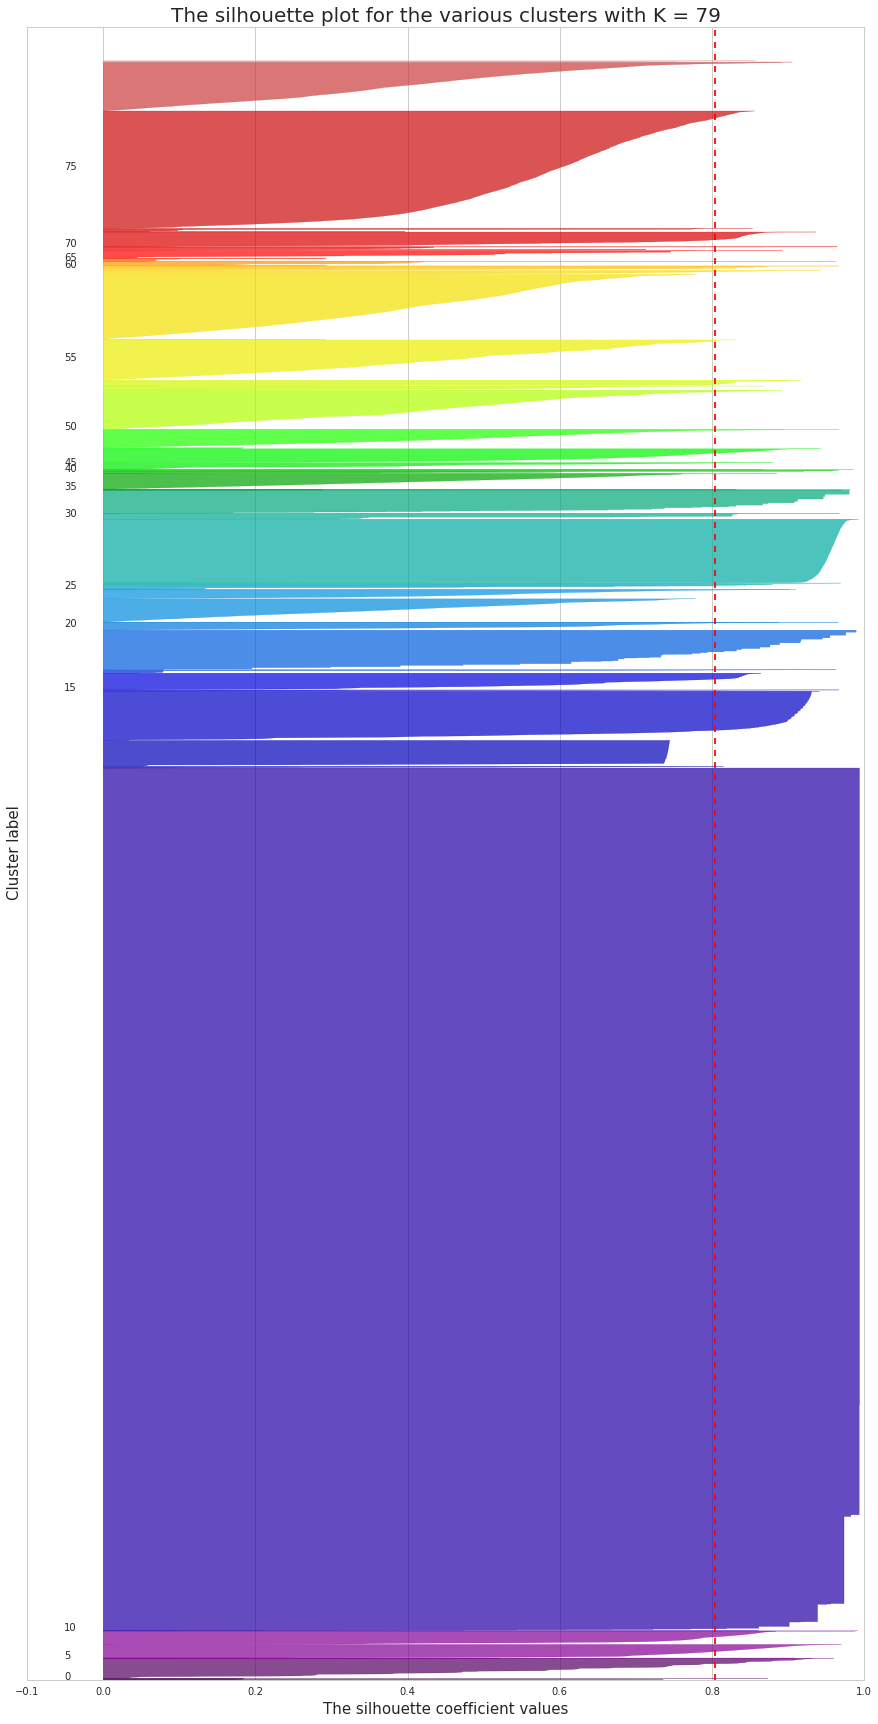

In [26]:
plot_silhouette(s_RDD, s_avg, clusters.k)

<div class="alert alert-success">
Here, we find some interesting characteristics: the first one is obviously the fact that there is a big cluster with a lot of points with the same (high) value of silhouette. From this consideration, we can draw a couple of theses: the first one is that there is a cluster (almost) exclusively formed by the same point; second, since the silhouette is very high, all these points are very far away from the others and create a well-defined cluster. Unfortunately, though, this element biases the entire score: even though a lot of points have a (very) low silhouette, the general score is reasonable high. 
</div>

<div class="alert alert-success">
Let's try using this metric for model selection
</div>

K = 5
Total not-empty clusters = 5
Silhouette = 0.808749506779
0. 1. 2. 3. 4. 

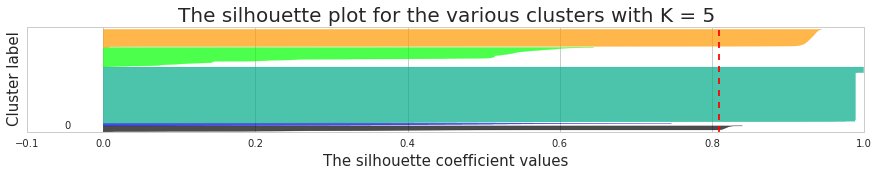

K = 10
Total not-empty clusters = 7
Silhouette = 0.845635891197
0. 1. 2. 3. 4. 5. 6. 

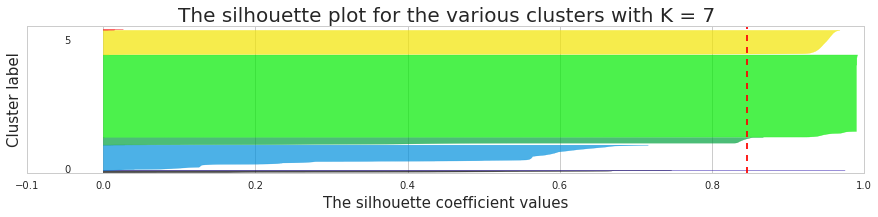

K = 50
Total not-empty clusters = 27
Silhouette = 0.811757252114
0. 1. 2. 3. 4. 5. 6. 7. 8. 9. 10. 11. 12. 13. 14. 15. 16. 17. 18. 19. 20. 21. 22. 23. 24. 25. 26. 

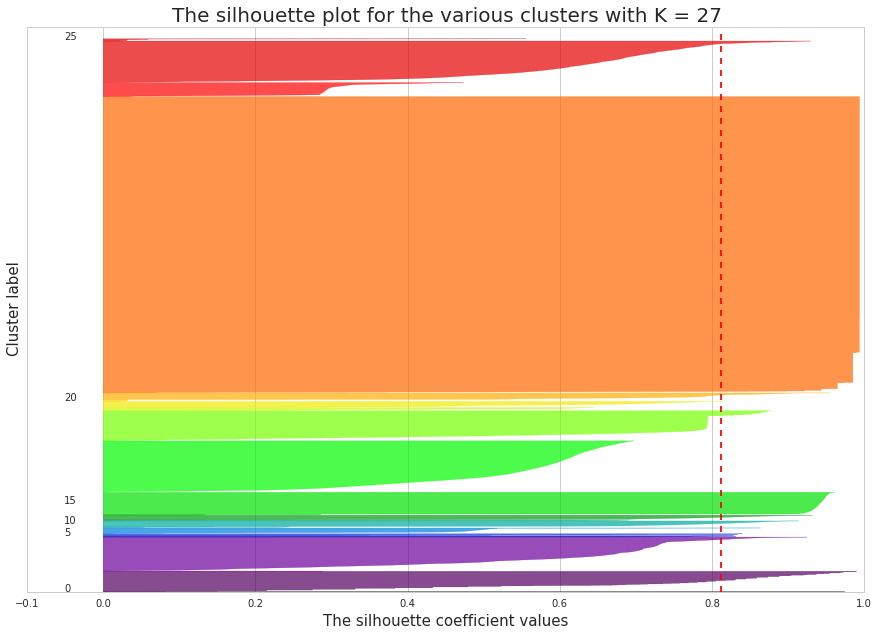

K = 150
Total not-empty clusters = 69
Silhouette = 0.818916232064
0. 1. 2. 3. 4. 5. 6. 7. 8. 9. 10. 11. 12. 13. 14. 15. 16. 17. 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35. 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48. 49. 50. 51. 52. 53. 54. 55. 56. 57. 58. 59. 60. 61. 62. 63. 64. 65. 66. 67. 68. 

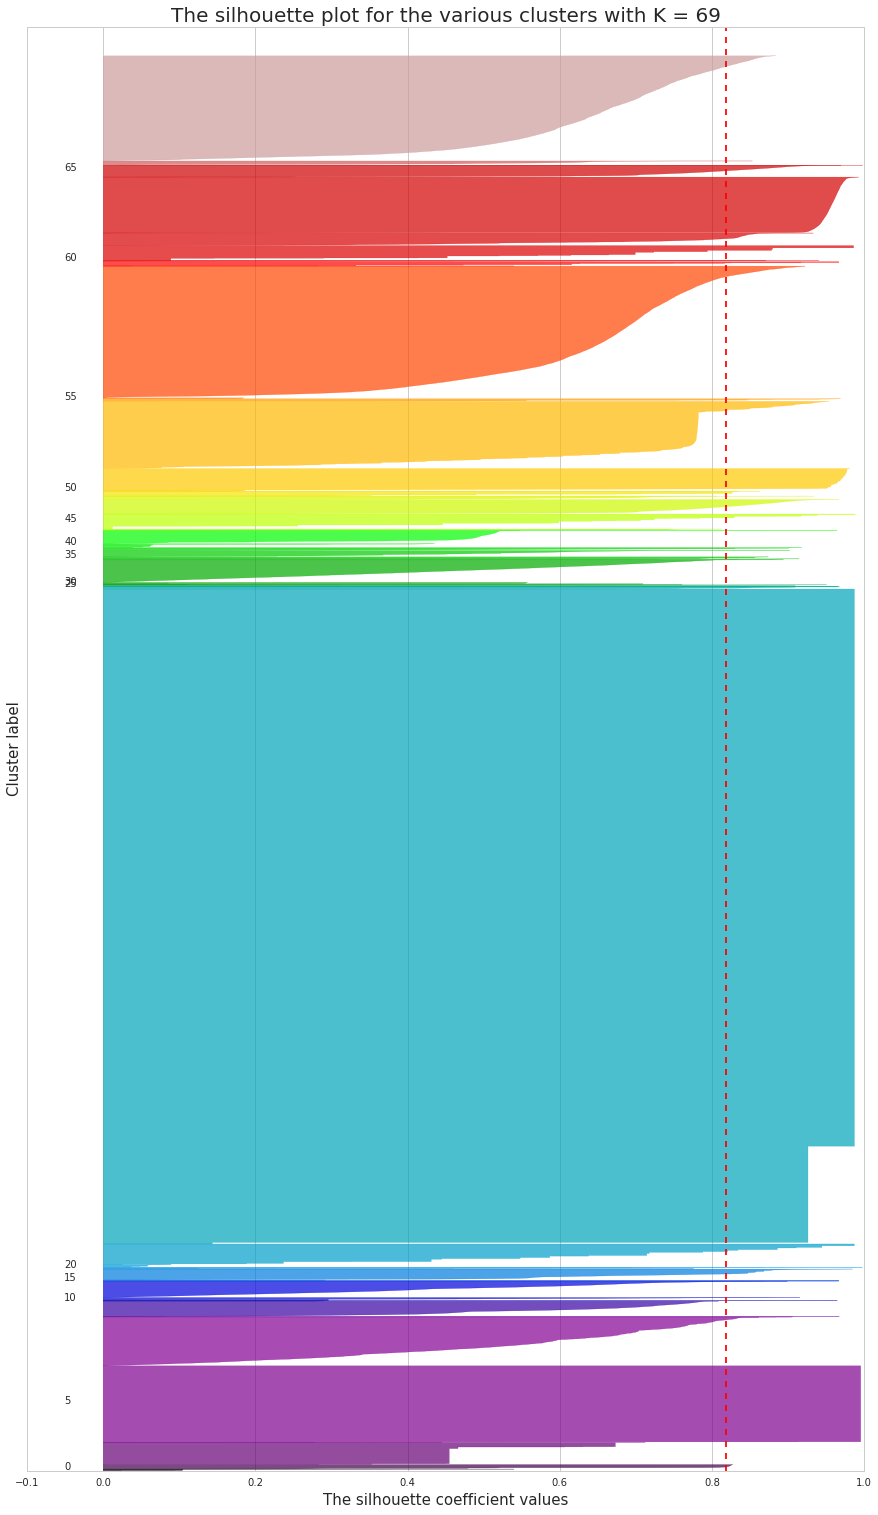

K = 200
Total not-empty clusters = 77
Silhouette = 0.807515112841
0. 1. 2. 3. 4. 5. 6. 7. 8. 9. 10. 11. 12. 13. 14. 15. 16. 17. 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35. 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48. 49. 50. 51. 52. 53. 54. 55. 56. 57. 58. 59. 60. 61. 62. 63. 64. 65. 66. 67. 68. 69. 70. 71. 72. 73. 74. 75. 76. 

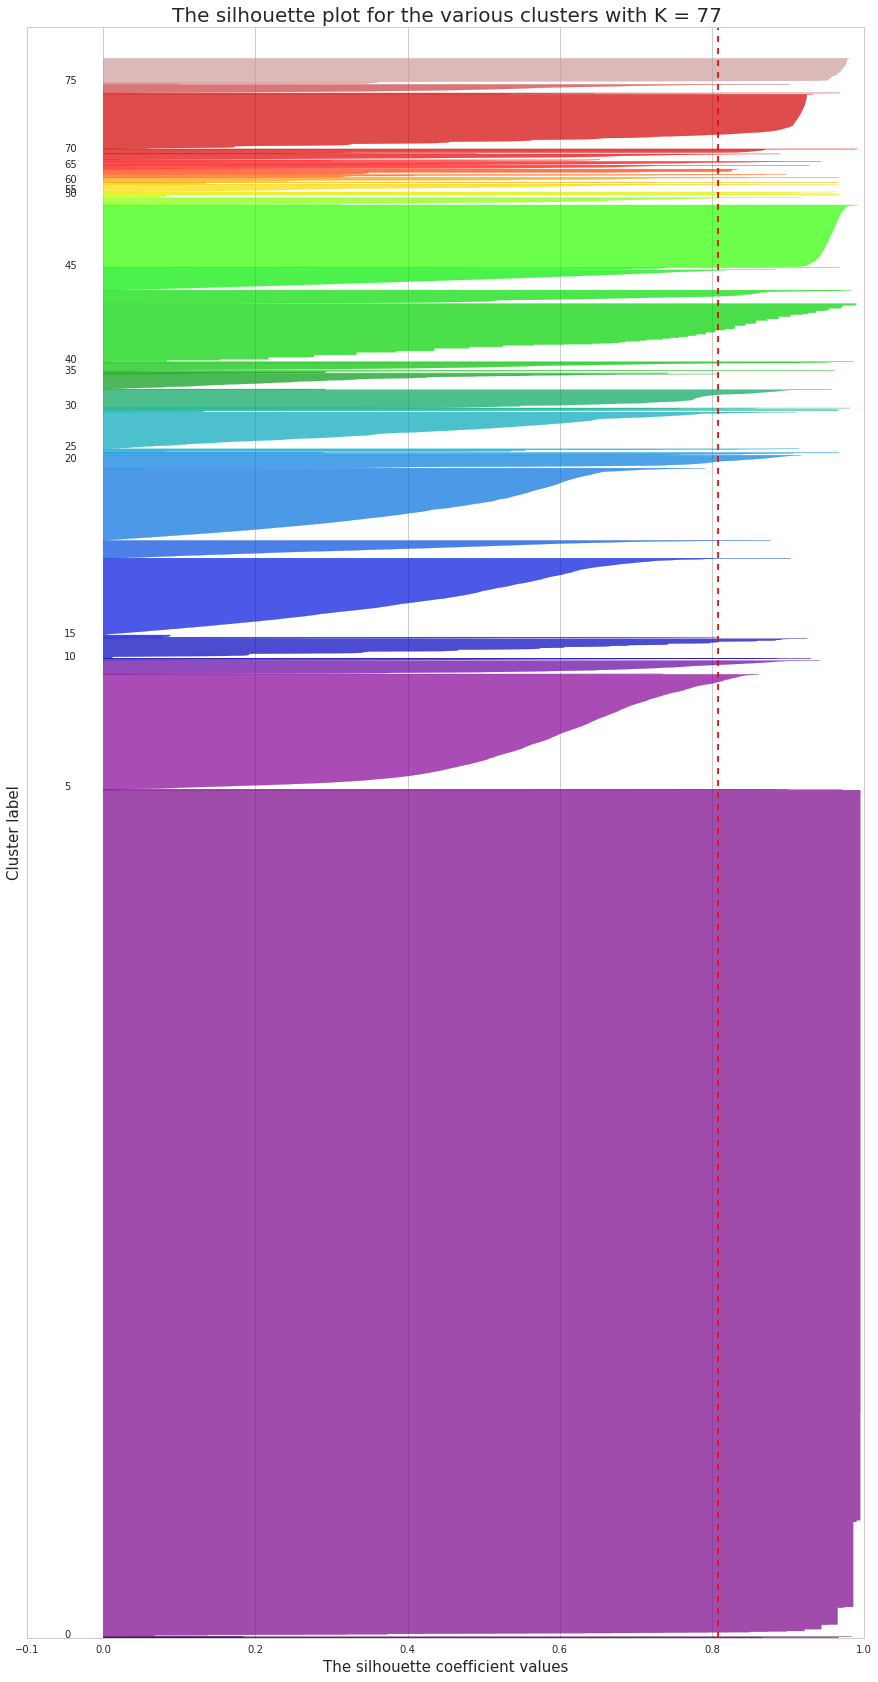

In [45]:
ks = [5, 10, 50, 150, 200]
for k in ks:
    print('K = ' + str(k))
    dataHotNormWithClusterNumber, clusters = train_and_predict(normalizedDataHot, k)
    print('Total not-empty clusters = ' + str(clusters.k))
    s_avg, s_RDD = compute_approx_silhouette(clusters.centers, dataHotNormWithClusterNumber)
    print('Silhouette = ' + str(s_avg))
    plot_silhouette(s_RDD, s_avg, clusters.k)

<div class="alert alert-success">
On this particular dataset, we don't think that the silhouette coefficient per se can be used for model selection. Since a lot of connections are equal (i.e. exactly with the same features), the result will be always biased. A feature work has to include a different definition for the silhouette score (likely a weighted average on the number of points).
</div>

#### Question 14
<div class="alert alert-info">

Implement K-means on Spark so that It can work with large datasets in parallel. Test your algorithm with our dataset in this notebook. Compare our algorithm with the algorithm from MLLIB.  

<ul></ul>

Let's clarify the meaning of this question: what we want is for students to design the K-means algorithm for the parallel programming model exposed by Spark. You are strongly invited to use the Python API (pyspark). So, at the end of the day, you will operate on RDDs, and implement a `map/reduce` algorithm that performs the two phases of the standard K-means algorithm, i.e. the assignment step and the update step.

</div>

In [3]:
def get_closest_centroid(centroids, point):
        """
                get_closest_centroid(centroids, point)
            
            Function to get the closest centroind
            Args:
                centroids (lis<np.array>):  List of all centroids
                point (np.array): Point under analysis
            Return:
                int: Index of the closest centroid
        -------------------------------------------------------------------------------------------------------------
        """

        distances = []
#        print(len(centroids))
        for i in range(len(centroids)):
            distances.append(euclidean_distance(centroids[i], point))
        distances = np.array(distances)

        return np.argmin(distances)

    
class Parallel_KMeans():
    """
                Parallel_KMeans Class

            Class for implementing a distribted version of the KMeans algorithm with Spark framework
        -------------------------------------------------------------------------------------------------------------
    """
    def __init__(self, k=2, initialisation='random', tol=1e-5):
        self.k_init = k
        self.initialisation = initialisation
        self.centroids = [None for _ in range(k)]
        self.tol = tol
   
    
    def __compute_score(self, dataWithCluster):
        bCentroids = sc.broadcast(self.centroids)
        score = dataWithCluster\
                    .map(lambda x: euclidean_distance(x[0], bCentroids.value[x[1]])**2)\
                    .reduce(lambda x,y : x + y)
        return score


    def __randomise_centroids(self, data):

        if self.initialisation == 'random':
            self.centroids = data.takeSample(False, self.k_init)
            #self.centroids = sc.broadcast(self.centroids)
        else:
            raise ValueError('\nInvalid initialisation method.\nAvailable methods:\n\t- random')

    def __assignment(self, data):
        """
            Function [private] for assignment step
            Args:
                data (RDD): RDD with all the training points in the format (<point>)
            Reurns:
                RDD: RDD with all the training points and their assignment in the format
                     (<point>, <cluster_number>)
        """
        bCentroids = sc.broadcast(self.centroids)
        #return data.map(lambda x : (x, self.__get_closest_centroid(bCentroids.value, x)))
        
        return data.map(lambda x : (x, get_closest_centroid(bCentroids.value, x)))

    def __update_centroids(self, dataWithClusters):
        """
            Function [private] for update step
            Args:
                dataWithClusters (RDD): RDD with all the training points and their
                                        assignment in the format (<point>, <cluster_number>)
        """
        
        #new_centroids = dataWithClusters.map(lambda x : (x[1], x[0].tolist())).groupByKey()\
        #                                .map(lambda x : (x[0], np.mean(np.array(list(x[1])), axis=0)))\
        #                                .collect()
                               
        
        sumCount = dataWithClusters.map(lambda x:(x[1], x[0]))\
                                   .combineByKey( lambda value: (value, 1),
                                                  lambda x, value: (x[0] + value, x[1] + 1),
                                                  lambda x, y: (x[0] + y[0], x[1] + y[1]))
        #averageByKey = sumCount.map(lambda (key, (value_sum, count)): (key, value_sum / count)).collect()
        new_centroids = sumCount.map(lambda x: (x[0], x[1][0] / x[1][1])).collect()
        
        new_centroids.sort(key=lambda x : x[0])
        
        self.k = len(list(map(lambda x:x[0], new_centroids)))
        new_centroids = list(map(lambda x:x[1], new_centroids))
        #new_score = self.__compute_score(dataWithClusters)
        #if np.abs(self.score - new_score) <= self.tol:
        #    self.__converged = True
        # 
        self.centroids = new_centroids
        #self.score = new_score
        
        return
    
    
    def train(self, data, num_iterations=100, num_runs=1, verbose=True):
        """
                train(self, data, num_iterations=100, num_runs=1, verbose=True)
                
            Train the KMean model
            Args:
                data (RDD): RDD with all the training points in the format (<point>)
                num_iterations (int) [default = 100]: Number of iteration for each update and assignment steps 
                                                      are executed
                num_runs (int) [default = 1]: Number of runs for each the randomize step is done. If greater 
                                              than one, it will automatically pick the best run
                verbose (book) [default = True]: Level of verbosity during training
            Return:
                None
        -------------------------------------------------------------------------------------------------------------
        """
        self.__converged = False
        self.__verbose = verbose
        print('Training with %d samples scheduled now.' % data.count(), end='\n\n') if verbose else 0
        # Randomize centroids
        
        list_of_centroids = []
        list_of_scores = []
        list_of_k = []
        
        for nr in range(num_runs):
            print('Starting run %d' % nr)
            self.__randomise_centroids(data)
            print('Randomize centroids done') if verbose else 0

            i = 0
            self.__score = 0
            self.__converged = False
            
            # While previuos_updates != 0 and i < iterations
            while not self.__converged and i < num_iterations:            
                i += 1

                t0 = time()
                
                dataWithClusters = self.__assignment(data)
                
                new_score = self.__compute_score(dataWithClusters)
                if np.abs(self.__score - new_score) <= self.tol:
                    self.__converged = True
                else:
                    self.__update_centroids(dataWithClusters)
                
                self.__score = new_score
                
                t1 = time()

                if verbose:
                    print('Iter ' + str(i) + ' done in %.2f seconds.' % (t1-t0), end=' ')
                    print('RSSE = %.2f' % np.sqrt(self.__score), end=' ')
                    print('K = %d' % self.k)

            print('Converged: '+ str(self.__converged), end='\n\n') if verbose else 0
            
            list_of_centroids.append(self.centroids)
            list_of_scores.append(self.__score)
            list_of_k.append(self.k)
            
        if num_runs > 1:    
            best_run = np.argmin(np.array(list_of_scores))
            self.__score = list_of_scores[best_run]
            self.centroids = list_of_centroids[best_run]
            self.k = list_of_k[best_run]
            print('Best run %d with RSSE = %.2f and K = %d' % (best_run, self.score, self.k)) if verbose else 0

    @property
    def score(self):
        return np.sqrt(self.__score)
    
    def predict(self, points):
        """
                predict(self, points)
                
            Predict the clusters assignment of given points
            Args:
                points (RDD): RDD with all the training points in the format (<point>)
            Return:
                RDD with all the points and their assignment in the format (<point>, <cluster_number>)
        -------------------------------------------------------------------------------------------------------------
        """
        return self.__assignment(points)
    

<div class="alert alert-success">
Let's print the documentation for this class and for some useful methods.
</div>

In [4]:
print(Parallel_KMeans.__doc__)


                Parallel_KMeans Class

            Class for implementing a distribted version of the KMeans algorithm with Spark framework
        -------------------------------------------------------------------------------------------------------------
    


In [5]:
print(get_closest_centroid.__doc__)


                get_closest_centroid(centroids, point)
            
            Function to get the closest centroind
            Args:
                centroids (lis<np.array>):  List of all centroids
                point (np.array): Point under analysis
            Return:
                int: Index of the closest centroid
        -------------------------------------------------------------------------------------------------------------
        


In [6]:
print(Parallel_KMeans.train.__doc__)


                train(self, data, num_iterations=100, num_runs=1, verbose=True)
                
            Train the KMean model
            Args:
                data (RDD): RDD with all the training points in the format (<point>)
                num_iterations (int) [default = 100]: Number of iteration for each update and assignment steps 
                                                      are executed
                num_runs (int) [default = 1]: Number of runs for each the randomize step is done. If greater 
                                              than one, it will automatically pick the best run
                verbose (book) [default = True]: Level of verbosity during training
            Return:
                None
        -------------------------------------------------------------------------------------------------------------
        


In [7]:
print(Parallel_KMeans.predict.__doc__)


                predict(self, points)
                
            Predict the clusters assignment of given points
            Args:
                points (RDD): RDD with all the training points in the format (<point>)
            Return:
                RDD with all the points and their assignment in the format (<point>, <cluster_number>)
        -------------------------------------------------------------------------------------------------------------
        


<div class="alert alert-success">
In this first test, we want to show the correctness on our implementation, running the algorithm with a small portion of points for 5 times, up to 100 iterations each.
</div>

In [39]:
kmeans = Parallel_KMeans(k=150, initialisation='random')
kmeans.train(normalizedDataHot.sample(False, 0.01, 0), num_iterations=100, num_runs=5)

Training with 48884 samples scheduled now.

Starting run 0
Randomize centroids done
Iter 1 done in 8.82 seconds. RSSE = 1945.08 K = 73
Iter 2 done in 5.82 seconds. RSSE = 1880.48 K = 70
Iter 3 done in 5.65 seconds. RSSE = 1558.14 K = 69
Iter 4 done in 6.97 seconds. RSSE = 1433.25 K = 69
Iter 5 done in 5.98 seconds. RSSE = 1365.19 K = 69
Iter 6 done in 5.75 seconds. RSSE = 1352.81 K = 69
Iter 7 done in 8.08 seconds. RSSE = 1326.34 K = 69
Iter 8 done in 7.62 seconds. RSSE = 1319.56 K = 69
Iter 9 done in 7.80 seconds. RSSE = 1318.69 K = 69
Iter 10 done in 7.69 seconds. RSSE = 1318.54 K = 69
Iter 11 done in 7.76 seconds. RSSE = 1318.48 K = 69
Iter 12 done in 7.93 seconds. RSSE = 1318.16 K = 69
Iter 13 done in 7.97 seconds. RSSE = 1318.15 K = 69
Iter 14 done in 7.71 seconds. RSSE = 1318.14 K = 69
Iter 15 done in 6.50 seconds. RSSE = 1318.14 K = 69
Iter 16 done in 5.67 seconds. RSSE = 1318.14 K = 69
Iter 17 done in 5.96 seconds. RSSE = 1318.14 K = 69
Iter 18 done in 5.80 seconds. RSSE = 1318

<div class="alert alert-success">
The algorithm converged every time and in the end the "image" of the best one has been restored, ready to be used for new predictions. 
<br>
<div class="label label-warning">Note:</div> our implementation automatically handles the case of void cluster and adapt itself to iteration after iteration.
</div>

<div class="alert alert-success">
In this second test, we show how our implementation scales with the number of points running the training with increasing number of samples.
</div>

In [34]:
kmeans = Parallel_KMeans(k=150, initialisation='random')
fract = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
for i in fract:
    kmeans.train(normalizedDataHot.sample(False, i, 0), num_iterations=3, num_runs=1)

Training with 490107 samples scheduled now.

Starting run 0
Randomize centroids done
Iter 1 done in 62.28 seconds. RSSE = 6826 K = 77
Iter 2 done in 32.85 seconds. RSSE = 6707 K = 77
Iter 3 done in 32.97 seconds. RSSE = 5850 K = 76
Converged: False

Training with 980101 samples scheduled now.

Starting run 0
Randomize centroids done
Iter 1 done in 113.55 seconds. RSSE = 9402 K = 78
Iter 2 done in 65.08 seconds. RSSE = 9202 K = 77
Iter 3 done in 64.70 seconds. RSSE = 8255 K = 73
Converged: False

Training with 1469040 samples scheduled now.

Starting run 0
Randomize centroids done
Iter 1 done in 170.90 seconds. RSSE = 11478 K = 71
Iter 2 done in 81.36 seconds. RSSE = 11266 K = 71
Iter 3 done in 84.38 seconds. RSSE = 10045 K = 71
Converged: False

Training with 1959991 samples scheduled now.

Starting run 0
Randomize centroids done
Iter 1 done in 227.82 seconds. RSSE = 13226 K = 82
Iter 2 done in 126.97 seconds. RSSE = 12867 K = 80
Iter 3 done in 120.80 seconds. RSSE = 11039 K = 78
Conve

<div class="alert alert-success">
From a preliminary analysis seems that our implementation scales linearly with the number of points (at least for the first iteration). Unfortunately, though, this is far away from being as much optimized as the one provided by Spark. Looking at the Spark UI, a lot of time seems to be lost when computing the new centroids and, in particular, in the `reduce` done by the `combineByKey` (used to emulate an average by key). 
</div>

<div class="alert alert-success">
<h1> Attack detection </h1>
<br>
So far we focused on finding connections that were <b>'different'</b>, regardless of their type (normal or malicious connection).
<br><br>
Here, we want to perform only <b>attack detection</b> using a different strategy: training with only on a subset (80%) of normal connections (trying to overfit on them) and then classifying points using distances from the closest cluster. If this distance is greater of a given threshold, then the connection is classified as intrusion. In prediction, the idea is that new normal connections will fall in one on these well defined clusters, while anomalous ones will be or should be far away from the center of these clusters.
</div>

In [23]:
normalizedLabelsAndDataHot = normalizeLabelsAndDataHot(labelsAndDataHot).cache()

In [32]:
normalConnectionPoints = normalizedLabelsAndDataHot.filter(lambda x: x[0]=='normal.').map(lambda x: x[1]).cache()
anomalyConnectionPoints = normalizedLabelsAndDataHot.filter(lambda x: x[0]!='normal.').map(lambda x: x[1]).cache()

In [120]:
model = KMeans.train(normalConnectionPoints.sample(False, 0.8, 0), 200, maxIterations=100, initializationMode="random")

In [121]:
bModel = sc.broadcast(model)
normalDistance = normalizedLabelsAndDataHot.filter(lambda x:x[0]=='normal.')\
                           .map(lambda x: (x[0], x[1], bModel.value.predict(x[1])))\
                           .map(lambda x: (x[0], euclidean_distance(x[1], bModel.value.centers[x[2]])))\
                           .map(lambda x:x[1]).cache()

In [143]:
print(model.k)

198


In [123]:
maxNormalDistance = normalDistance.max()
minNormalDistance = normalDistance.min()
avgNormalDistance = normalDistance.mean()

In [124]:
print('Max = ' + str(maxNormalDistance))
print('Min = ' + str(minNormalDistance))
print('Avg = ' + str(avgNormalDistance))

Max = 2587.23173336
Min = 0.00440959653941
Avg = 0.973146863776


In [125]:
def exceeding_threshold(distance, t):
    if distance > t:
        return 'anomaly'
    else:
        return 'standard'

In [126]:
predictionsMax = normalizedLabelsAndDataHot.map(lambda x : (x[0], x[1], bModel.value.predict(x[1])))\
                          .map(lambda x : (x[0], euclidean_distance(x[1], bModel.value.centers[x[2]])))\
                          .map(lambda x : (x[0], exceeding_threshold(x[1], maxNormalDistance)))\
                          .cache()
predictionsAvg = normalizedLabelsAndDataHot.map(lambda x : (x[0], x[1], bModel.value.predict(x[1])))\
                          .map(lambda x : (x[0], euclidean_distance(x[1], bModel.value.centers[x[2]])))\
                          .map(lambda x : (x[0], exceeding_threshold(x[1], avgNormalDistance)))\
                          .cache()

In [127]:
TP_max = predictionsMax.filter(lambda x : x[0] == 'normal.' and x[1] == 'standard').count()
FP_max = predictionsMax.filter(lambda x : x[0] == 'normal.' and x[1] == 'anomaly').count()
TN_max = predictionsMax.filter(lambda x : x[0] != 'normal.' and x[1] == 'anomaly').count()
FN_max = predictionsMax.filter(lambda x : x[0] != 'normal.' and x[1] == 'standard').count()

In [142]:
print('TP = %.0f' % TP_max)
print('FP = %.0f' % FP_max)
print('TN = %.0f' % TN_max)
print('FN = %.0f' % FN_max)
print()

ACC_max = (TP_max + TN_max) / (TP_max + FP_max + TN_max + FN_max)
print('Accuracy = %.4f' % ACC_max)

sensitivity_max = TP_max / (TP_max + FN_max)
print('Sensitivity = %.4f' % sensitivity_max)

specificity_max = np.divide(TN_max, (FP_max + TN_max))
print('Specificity = %.4f' % specificity_max)

TP = 972781
FP = 0
TN = 1
FN = 3925650

Accuracy = 0.1986
Sensitivity = 0.1986
Specificity = 1.0000


<div class="alert alert-success">
It's seems that with this threshold we cannot identify any anomaly.
<br><br>
Let's now use the average distance as threshold.
</div>

In [129]:
TP_avg = predictionsAvg.filter(lambda x : x[0] == 'normal.' and x[1] == 'standard').count()
FP_avg = predictionsAvg.filter(lambda x : x[0] == 'normal.' and x[1] == 'anomaly').count()
TN_avg = predictionsAvg.filter(lambda x : x[0] != 'normal.' and x[1] == 'anomaly').count()
FN_avg = predictionsAvg.filter(lambda x : x[0] != 'normal.' and x[1] == 'standard').count()

In [140]:
print('TP = %.0f' % TP_avg)
print('FP = %.0f' % FP_avg)
print('TN = %.0f' % TN_avg)
print('FN = %.0f' % FN_avg)
print()

ACC_avg = (TP_avg + TN_avg) / (TP_avg + FP_avg + TN_avg + FN_avg)
print('Accuracy = %.4f' % ACC_avg)

sensitivity_avg = TP_avg / (TP_avg + FN_avg)
print('Sensitivity = %.4f' % sensitivity_avg)

specificity_avg = np.divide(TN_avg, (FP_avg + TN_avg))
print('Specificity = %.4f' % specificity_avg)

TP = 774044
FP = 198737
TN = 3925630
FN = 20

Accuracy = 0.9594
Sensitivity = 1.0000
Specificity = 0.9518


<div class="alert alert-success">
This is really interesting, using the average distance between centroids, the accuracy is way higher than before and almost all the anomalies can be detected. 
</div>

<div class="alert alert-success">
<h1>Future works</h1>
<ul>
<li>Looking at the Scala source code to the Spark's KMeans, we found that the mean of a set of points has been implemented using `accumulators`. For this reason, we think that the first thing to do in order to optimize the running time of our model is to re-implement the centroids update using `accumulators`.</li>
<li>Since each run and each initialisation of a KMean train is independent from the others, the natural extension for multiple runs is multiple parallel runs, associating different run to different workers or set of workers.</li>
<li>Use other metrics for distances: since a lot of features are binary (0/1), it may be convenient to use other distances, mostly Manhattan distance or Hamming distance.</li>
<li>Reduce the dimensionality of the problem using some kind of linear or non linear dimensionality reduction.</li>
</ul>
</div>

<div class="alert alert-success">
<h1>References</h1>
<br>
`[1] http://jeffsoh.blogspot.fr/2013/03/port-scan-versus-port-sweep.html`
<br>
`[2] https://cs.fit.edu/~pkc/classes/ml-internet/silhouette.pdf`
<br>
`[3] https://hal.archives-ouvertes.fr/file/index/docid/736278/filename/paper_comcom_2011.pdf`
<br>
`[4] http://ieeexplore.ieee.org/document/6104014/`
</div>